In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

Using TensorFlow backend.


In [2]:
#GLOBAL Variables
BATCH_SIZE = 128 
EPOCHS_BASE = 50 #or 100
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2

In [3]:
#folder = "./Sentiment/twitter/"
folder = "./Sentiment/rotten//"

### Load Data and preprocess

In [4]:
import re
FLAGS = re.MULTILINE | re.DOTALL
def allcaps(text):
    text = text.group()
    return text.lower() + " <allcaps>"
def tokenize(text):
    # Different regex parts for smiley faces
    eyes = r"[8:=;]"
    nose = r"['`\-]?"
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
    text = re_sub(r"/"," / ")
    text = re_sub(r"@\w+", "<user>")
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<smile>")
    text = re_sub(r"{}{}p+".format(eyes, nose), "<lolface>")
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<sadface>")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "<neutralface>")
    text = re_sub(r"<3","<heart>")
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<number>")
    text = re_sub(r"#\S+", "<hashtag>")
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")

    ## -- I just don't understand why the Ruby script adds <allcaps> to everything so I limited the selection.
    # text = re_sub(r"([^a-z0-9()<>'`\-]){2,}", allcaps)
    text = re_sub(r"([A-Z]){2,}", allcaps)
    return text.lower()

def read_texts(filename):
    f = open(filename)
    data = [line.strip() for line in f]
    f.close()
    return data

#texts_train = [tokenize(text) for text in read_texts(folder+"texts_train.txt")]
texts_train = read_texts(folder+"texts_train.txt")
#texts_test = [tokenize(text) for text in read_texts(folder+"texts_test.txt")]
texts_test = read_texts(folder+"texts_test.txt")

Z_train = np.loadtxt(folder+"sent_train.txt", dtype='int')
Z_test = np.loadtxt(folder+"sent_test.txt", dtype='int')

print("Num. train texts: %d" % len(texts_train))
print("Num. test texts:  %d" % len(texts_test))

Num. train texts: 4999
Num. test texts:  6000


In [5]:
from keras import preprocessing
MAX_NB_WORDS = 13000
tokenizer = preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts_train+texts_test)
sequences_train = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)
#MAX_NB_WORDS = len(tokenizer.word_index)
print('Found %s unique tokens.' % len(tokenizer.word_index))

Found 14552 unique tokens.


(-100, 13000)

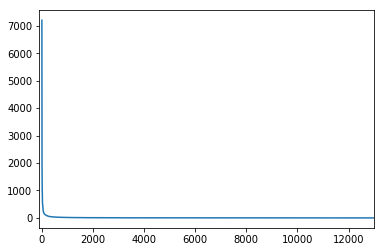

In [6]:
aux = np.asarray(list(tokenizer.word_counts.values()))
plt.plot(np.sort(aux)[::-1])
plt.xlim(-100,MAX_NB_WORDS)

In [6]:
lens = list(map(len,sequences_train))
max_L = np.max(lens)
print("Real max: ",max_L)
max_L = 50 
print("Used max: ",max_L)

X_train = preprocessing.sequence.pad_sequences(sequences_train, maxlen=max_L,dtype='int32', value=0,padding='pre')
X_test = preprocessing.sequence.pad_sequences(sequences_test, maxlen=max_L,dtype='int32', value=0,padding='pre')
print('Shape of train tensor:', X_train.shape)

Real max:  51
Used max:  50
Shape of train tensor: (4999, 50)


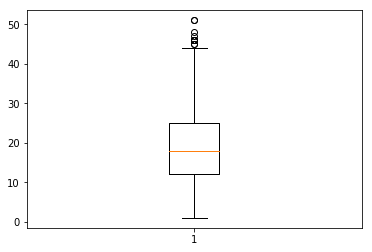

In [12]:
plt.boxplot(lens)
plt.show()

In [7]:
EMBEDDING_DIM = 300
GLOVE_FILE = "../AUX_DATA/glove.6B/glove.6B.%dd.txt"%(EMBEDDING_DIM)
#GLOVE_FILE = "../AUX_DATA/glove.twitter.27B/glove.twitter.27B.%dd.txt"%(EMBEDDING_DIM)

embeddings_index = {}
with open(GLOVE_FILE) as file:
    for line in file:
        values = line.split()
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[values[0]] = coefs
print('Preparing embedding matrix.')
sorted_x = sorted(tokenizer.word_counts.items(), key=lambda kv: kv[1], reverse=True)
vocab = {value[0]:tokenizer.word_index[value[0]] for i, value in enumerate(sorted_x) if i < MAX_NB_WORDS}
embedding_matrix = np.zeros((len(vocab)+1, EMBEDDING_DIM))
v=0
for word, i in vocab.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector # words not found in embedding index will be all-zeros.
        v+=1
del embeddings_index, sorted_x, tokenizer
gc.collect()
print("Words found on glove: ",v)

Preparing embedding matrix.
Words found on glove:  12049


### Load annotations / Generate

In [8]:
from code.representation import *
from code.utils import *

In [9]:
print("Loading AMT data...")
y_obs = np.loadtxt(folder+"answers.txt", delimiter=' ', dtype='int16')
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

N,T = y_obs.shape
Kl = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",Kl)

Loading AMT data...
Shape (data,annotators):  (4999, 203)
Classes:  2


In [17]:
#every annotation is one annotator
total_annotations = T_weights.sum(axis=0)
new_annotations = np.ones((N, total_annotations),dtype='int16')*-1
t_aux = 0
for i in range(y_obs.shape[0]):
    for t in range(y_obs.shape[1]):
        if y_obs[i,t] != -1:
            new_annotations[i,t_aux] = y_obs[i,t]
            t_aux+=1
new_annotations.shape

(1000, 2547)

In [30]:
np.savetxt(folder+"answers_v2.txt",new_annotations, delimiter=",", fmt="%i")

In [ ]:
##  volver a pensar mejor lo de abajo..

In [10]:
#generate conf matrix...
confe_matrix_R = np.zeros((T,Kl,Kl),dtype=DTYPE_OP) #rodrigues add epsilon here
for t in range(T):    
    for i in range(N):
        if y_obs[i,t] != -1:
            confe_matrix_R[t,Z_train[i],y_obs[i,t]] +=1
            
    mask_nan = confe_matrix_R[t,:,:].sum(axis=-1) == 0
    mean_replace = np.mean(confe_matrix_R[t,:,:][~mask_nan],axis=0)
    for value in np.arange(Kl)[mask_nan]:
        confe_matrix_R[t,value,:] =  1 #Rodrigues 1./K -- similar  to laplace smooth (prior 1)
    confe_matrix_R[t,:,:] = confe_matrix_R[t,:,:]/confe_matrix_R[t,:,:].sum(axis=-1,keepdims=True) #normalize
confe_matrix_R

array([[[0.7058824 , 0.29411766],
        [0.33333334, 0.6666667 ]],

       [[0.94827586, 0.05172414],
        [0.13733906, 0.86266094]],

       [[0.9756098 , 0.02439024],
        [0.10526316, 0.8947368 ]],

       [[0.9306358 , 0.06936416],
        [0.07629428, 0.9237057 ]],

       [[0.94011974, 0.05988024],
        [0.22839506, 0.77160496]],

       [[0.6469111 , 0.3530889 ],
        [0.16083916, 0.83916086]],

       [[0.9344    , 0.0656    ],
        [0.07922272, 0.92077726]],

       [[0.8918919 , 0.10810811],
        [0.11267605, 0.8873239 ]],

       [[0.625     , 0.375     ],
        [0.3809524 , 0.61904764]],

       [[0.81389576, 0.18610422],
        [0.13315926, 0.8668407 ]],

       [[0.8372093 , 0.1627907 ],
        [0.22891566, 0.7710843 ]],

       [[0.89830506, 0.10169491],
        [0.06      , 0.94      ]],

       [[0.9122807 , 0.0877193 ],
        [0.14655173, 0.8534483 ]],

       [[0.9301165 , 0.06988353],
        [0.12522046, 0.8747795 ]],

       [[0.7702703 ,

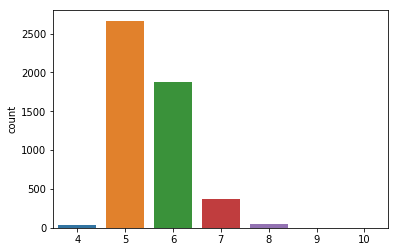

Minimum annotations in a example:  4
Maximum annotations in a example:  10
T data (expected value):  5.550310062012403
Graphics of T weights


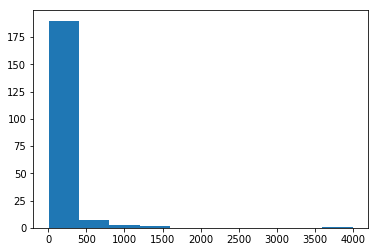

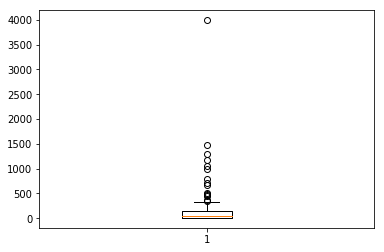

Minimum annotations by an annotator:  5
Maximum annotations by an annotator:  3993
Mean annotations by an annotator:  136.67980295566502


In [11]:
#graphics and distribution? what is T_data
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

#### Delta Convergence criteria

In [12]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN_text,CNN_simple, RNN_simple, default_CNN_text

from code.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model -- ideal

In [13]:
Z_train_onehot = keras.utils.to_categorical(Z_train)

model_UB = default_RNN_text(max_L, Kl, embed_M=embedding_matrix)
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
hist = model_UB.fit(X_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_UB.predict_classes(X_train)
Z_test_pred = model_UB.predict_classes(X_test)

Trained IDeal Model, Epochs to converge = 8


In [13]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')

mv_probas, mv_conf_probas = label_I.mv_labels('probas')
mv_onehot, mv_conf_onehot = label_I.mv_labels('onehot')

Z_train_onehot = keras.utils.to_categorical(Z_train)
Z_test_onehot = keras.utils.to_categorical(Z_test)

Representation for MV in 0.201636 sec
Representation for DS in 0.104181 sec
Estimation MV in 0.000460 sec


In [14]:
from keras.models import Sequential,Model
from keras.layers import *
def default_CNN_text(input_dim,output_dim,embed_M=[]):
    model = Sequential() 
    if len(embed_M) != 0:
        T, R_t = embed_M.shape
        emd_layer = Embedding(T, R_t,trainable=False,weights=[embed_M],input_length=input_dim)
        model.add(emd_layer)
    else:
        model.add(InputLayer(input_shape=input_dim))
    model.add(Conv1D(128, 3, activation='relu')) #kernel 5?
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.5))
    
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.5))
    
    model.add(GlobalAveragePooling1D())
    
    #model.add(Flatten())
    #model.add(Dense(32, activation='relu'))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.25))
    
    model.add(Dense(output_dim, activation='softmax')) 
    return model
## muy parecida a la recurrente-.--

In [114]:
def default_RNN_text(input_dim,output_dim,embed_M=[]): 
    model = Sequential() 
    if len(embed_M) != 0:
        T, R_t = embed_M.shape
        emd_layer = Embedding(T, R_t,trainable=False,weights=[embed_M],input_length=input_dim)
        model.add(emd_layer)
    else:
        model.add(InputLayer(input_shape=input_dim))
    #dropa here..
    #model.add(Dropout(0.2))
    
    #model.add(GRU(128,return_sequences=False, dropout=0.2, recurrent_dropout=0.5)) #dropout=0.2, recurrent_dropout=0.2) #o 256/128
    
    model.add(CuDNNGRU(64,return_sequences=True))
    model.add(Dropout(0.5))
    
    model.add(CuDNNGRU(32,return_sequences=False)) #128 funciona con embd 100 (sin otra capa)
    model.add(Dropout(0.5))
    
    model.add(Dense(output_dim, activation='softmax'))     
    return model

In [121]:
model_UB = default_RNN_text(max_L, Kl, embed_M=embedding_matrix)
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT, metrics=["accuracy"])
model_UB.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_38 (Embedding)     (None, 50, 300)           3900300   
_________________________________________________________________
cu_dnngru_52 (CuDNNGRU)      (None, 50, 64)            70272     
_________________________________________________________________
dropout_55 (Dropout)         (None, 50, 64)            0         
_________________________________________________________________
cu_dnngru_53 (CuDNNGRU)      (None, 32)                9408      
_________________________________________________________________
dropout_56 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 2)                 66        
Total params: 3,980,046
Trainable params: 79,746
Non-trainable params: 3,900,300
_____________________________________________________________

In [122]:
hist=model_UB.fit(X_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=2,callbacks=[ourCallback]
                  ,validation_data=(X_test,Z_test_onehot))
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))

Train on 4999 samples, validate on 6000 samples
Epoch 1/50
 - 5s - loss: 0.6755 - acc: 0.5839 - val_loss: 0.5895 - val_acc: 0.7023
Epoch 2/50
 - 1s - loss: 0.5639 - acc: 0.7127 - val_loss: 0.5457 - val_acc: 0.7330
Epoch 3/50
 - 1s - loss: 0.5017 - acc: 0.7646 - val_loss: 0.5278 - val_acc: 0.7483
Epoch 4/50
 - 1s - loss: 0.4791 - acc: 0.7746 - val_loss: 0.5192 - val_acc: 0.7477
Epoch 5/50
 - 1s - loss: 0.4482 - acc: 0.8010 - val_loss: 0.5189 - val_acc: 0.7443
Epoch 6/50
 - 1s - loss: 0.4291 - acc: 0.8050 - val_loss: 0.6102 - val_acc: 0.6775
Epoch 7/50
 - 1s - loss: 0.4775 - acc: 0.7768 - val_loss: 0.5114 - val_acc: 0.7517
Epoch 8/50
 - 1s - loss: 0.4039 - acc: 0.8254 - val_loss: 0.5164 - val_acc: 0.7440
Epoch 9/50
 - 1s - loss: 0.3825 - acc: 0.8354 - val_loss: 0.5173 - val_acc: 0.7458
Epoch 10/50
 - 1s - loss: 0.3610 - acc: 0.8424 - val_loss: 0.5157 - val_acc: 0.7462
Epoch 11/50
 - 1s - loss: 0.3356 - acc: 0.8604 - val_loss: 0.5303 - val_acc: 0.7427
Epoch 12/50
 - 1s - loss: 0.3382 - ac

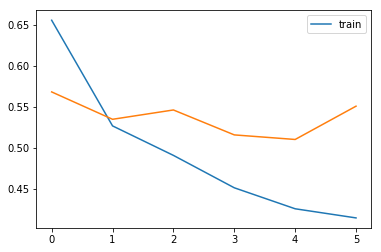

In [113]:
plt.plot(hist.history["loss"],label="train")
plt.plot(hist.history["val_loss"])
plt.legend()

In [47]:
Z_train_pred = model_UB.predict_classes(X_train)
Z_test_pred = model_UB.predict_classes(X_test)

evaluate = Evaluation_metrics(model_UB,'keras',X_train.shape[0])
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

NameError: name 'Evaluation_metrics' is not defined

In [138]:
model_mvsoft = keras.models.clone_model(model_UB)
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvsoft.fit(X_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=2,callbacks=[ourCallback]
                     ,validation_data=(X_test,Z_test_onehot))
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))

Train on 1000 samples, validate on 9000 samples
Epoch 1/50
 - 2s - loss: 0.6633 - val_loss: 0.7350
Epoch 2/50
 - 0s - loss: 0.6068 - val_loss: 0.8441
Epoch 3/50
 - 0s - loss: 0.5940 - val_loss: 0.7778
Epoch 4/50
 - 0s - loss: 0.5916 - val_loss: 0.7930
Epoch 5/50
 - 0s - loss: 0.5894 - val_loss: 0.8123
Epoch 6/50
 - 0s - loss: 0.5869 - val_loss: 0.7873
Epoch 7/50
 - 0s - loss: 0.5837 - val_loss: 0.8070
Epoch 8/50
 - 1s - loss: 0.5816 - val_loss: 0.8087
Epoch 9/50
 - 0s - loss: 0.5774 - val_loss: 0.7849
Epoch 10/50
 - 0s - loss: 0.5722 - val_loss: 0.8124
Epoch 11/50
 - 0s - loss: 0.5659 - val_loss: 0.7888
Epoch 12/50
 - 0s - loss: 0.5574 - val_loss: 0.8096
Epoch 13/50
 - 0s - loss: 0.5479 - val_loss: 0.8031
Epoch 14/50
 - 0s - loss: 0.5378 - val_loss: 0.7922
Epoch 15/50
 - 0s - loss: 0.5452 - val_loss: 0.7404
Epoch 16/50
 - 0s - loss: 0.5308 - val_loss: 0.8694
Epoch 17/50
 - 0s - loss: 0.5222 - val_loss: 0.7849
Epoch 18/50
 - 0s - loss: 0.5158 - val_loss: 0.8756
Epoch 19/50
 - 0s - loss:

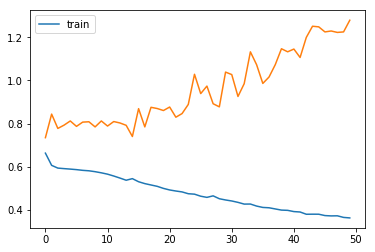

In [139]:
plt.plot(hist.history["loss"],label="train")
plt.plot(hist.history["val_loss"])
plt.legend()

### Infer Labels (without predictive model)

In [16]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')

mv_probas, mv_conf_probas = label_I.mv_labels('probas')
mv_onehot, mv_conf_onehot = label_I.mv_labels('onehot')

confe_matrix_G = get_Global_confusionM(Z_train,label_I.y_obs_repeat)

if y_obs.shape[1] <= 12000:
    ds_labels,ds_conf = label_I.DS_labels()

Representation for MV in 0.210023 sec
Representation for DS in 0.273346 sec
Estimation MV in 0.000428 sec
Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -14653.166498367373
2 	 -13799.35488288413 	0.0437	0.259030	0.058268
3 	 -13743.9426277318 	0.0171	0.135132	0.004016
4 	 -13734.486450749268 	0.0083	0.096952	0.000688
5 	 -13731.737667186568 	0.0047	0.066205	0.000200
6 	 -13730.743327413635 	0.0029	0.047743	0.000072
7 	 -13730.309246011282 	0.0018	0.036592	0.000032
8 	 -13730.081175084595 	0.0012	0.028339	0.000017
Class marginals
[0.5 0.5]
Estimation for DS in 6.207016 sec


In [17]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ACC MV on train: 0.8895779155831166
ACC D&S on train: 0.9151830366073215


In [20]:
model_mvsoft = keras.models.clone_model(model_UB)
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvsoft.fit(X_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvsoft.predict_classes(X_train)
Z_test_pred = model_mvsoft.predict_classes(X_test)

Trained model over soft-MV, Epochs to converge = 2


In [22]:
model_mvhard = keras.models.clone_model(model_UB)
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvhard.fit(X_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvhard.predict_classes(X_train)
Z_test_pred = model_mvhard.predict_classes(X_test)

Trained model over hard-MV, Epochs to converge = 2


In [27]:
model_ds = keras.models.clone_model(model_UB)
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_ds.fit(X_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_ds.predict_classes(X_train)
Z_test_pred = model_ds.predict_classes(X_test)

Trained model over D&S, Epochs to converge = 2


### Raykar Model (joint predict model)

In [14]:
from code.baseline import RaykarMC
y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
print("shape:",y_obs_categorical.shape)

shape: (4999, 203, 2)


In [15]:
raykarMC = RaykarMC(max_L, y_obs_categorical.shape[-1], T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("default rnn text", embed=embedding_matrix)

logL_hists,i_r = raykarMC.multiples_run(20,X_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

Initializing new EM...
Betas shape:  (203, 2, 2)
Q estimate shape:  (4999, 2)
Iter 1/50 
M step: done,  E step: done //  (in 3.28 sec)	logL: -14731.192	
Iter 2/50 
M step: done,  E step: done //  (in 0.89 sec)	logL: -13768.369	Tol1: 0.06536	Tol2: 0.17651	
Iter 3/50 
M step: done,  E step: done //  (in 0.84 sec)	logL: -13584.618	Tol1: 0.01335	Tol2: 0.04707	
Iter 4/50 
M step: done,  E step: done //  (in 0.85 sec)	logL: -13460.758	Tol1: 0.00912	Tol2: 0.01788	
Finished training
Initializing new EM...
Betas shape:  (203, 2, 2)
Q estimate shape:  (4999, 2)
Iter 1/50 
M step: done,  E step: done //  (in 2.93 sec)	logL: -14744.022	
Iter 2/50 
M step: done,  E step: done //  (in 0.90 sec)	logL: -13801.939	Tol1: 0.06390	Tol2: 0.17632	
Iter 3/50 
M step: done,  E step: done //  (in 0.84 sec)	logL: -13662.875	Tol1: 0.01008	Tol2: 0.04671	
Iter 4/50 
M step: done,  E step: done //  (in 0.82 sec)	logL: -13523.295	Tol1: 0.01022	Tol2: 0.01935	
Finished training
Initializing new EM...
Betas shape:  (20

M step: done,  E step: done //  (in 2.76 sec)	logL: -14744.087	
Iter 2/50 
M step: done,  E step: done //  (in 0.82 sec)	logL: -13761.209	Tol1: 0.06666	Tol2: 0.17629	
Iter 3/50 
M step: done,  E step: done //  (in 0.80 sec)	logL: -13624.883	Tol1: 0.00991	Tol2: 0.04824	
Iter 4/50 
M step: done,  E step: done //  (in 0.81 sec)	logL: -13507.964	Tol1: 0.00858	Tol2: 0.02211	
Finished training
Initializing new EM...
Betas shape:  (203, 2, 2)
Q estimate shape:  (4999, 2)
Iter 1/50 
M step: done,  E step: done //  (in 2.72 sec)	logL: -14743.552	
Iter 2/50 
M step: done,  E step: done //  (in 0.83 sec)	logL: -13797.059	Tol1: 0.06420	Tol2: 0.17635	
Iter 3/50 
M step: done,  E step: done //  (in 0.84 sec)	logL: -13584.756	Tol1: 0.01539	Tol2: 0.04712	
Iter 4/50 
M step: done,  E step: done //  (in 0.80 sec)	logL: -13480.761	Tol1: 0.00766	Tol2: 0.01687	
Finished training
Initializing new EM...
Betas shape:  (203, 2, 2)
Q estimate shape:  (4999, 2)
Iter 1/50 
M step: done,  E step: done //  (in 2.71

In [16]:
Z_train_p = raykarMC.get_predictions(X_train)
Z_train_pred =Z_train_p.argmax(axis=-1)
Z_test_p = raykarMC.get_predictions(X_test)
Z_test_pred = Z_test_p.argmax(axis=-1)

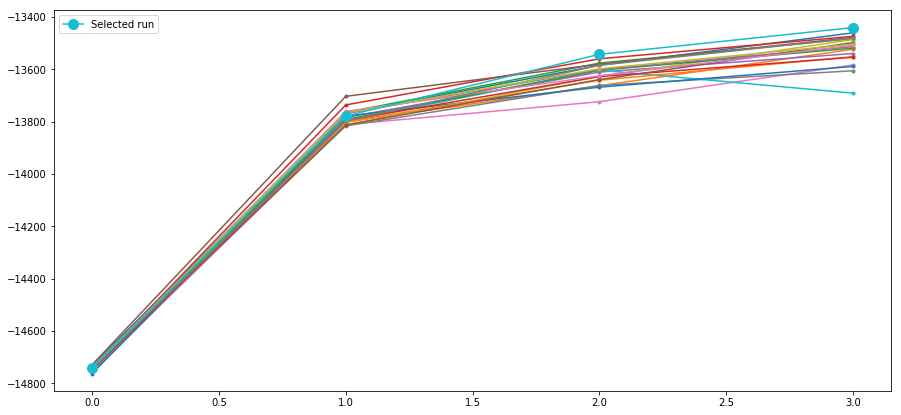

In [17]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Our Proposed

In [18]:
from code.MixtureofGroups import GroupMixtureGlo, GroupMixtureInd

In [19]:
""" AÑADIR A ARCHIVO GROUPS..."""
def define_uniform_groups(power, r, M):
    R_total = r.sum()
    uniform_groups = np.asarray([power*R_total/M for _ in range(M)])
    return uniform_groups

#get our representation 
r_obs = set_representation(y_obs,"repeat")
confe_matrix_G = get_Global_confusionM(Z_train,r_obs)

print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

vector of repeats:
 [[0 5]
 [5 0]
 [4 2]
 ...
 [2 4]
 [1 4]
 [3 2]]
shape: (4999, 2)


There is low entropy (information), maybe there is only a few groups in this dataset, the possible of different behavior is low.

Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.006591 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Alphas:  (5,)
MV init:  (4999, 2)
Betas:  (5, 2, 2)
Q estimate:  (4999, 2, 5, 2)
Iter 1/0
M step: done,  E step: done //  (in 1.49 sec)	logL: -19351.873	
Finished training!


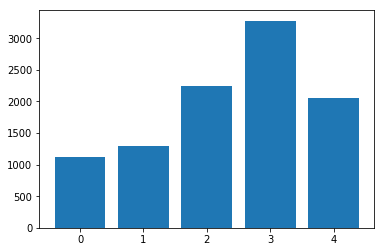

<BarContainer object of 5 artists>

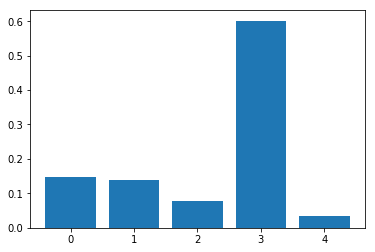

In [22]:
gMixture_Global = GroupMixtureGlo(max_L,Kl=r_obs.shape[1],M=5,epochs=0,optimizer=OPT,dtype_op=DTYPE_OP) 

gMixture_Global.define_model("default rnn text", embed=embedding_matrix)

logL_hists,i_r = gMixture_Global.multiples_run(1,X_train,r_obs,batch_size=BATCH_SIZE,max_iter=0,tolerance=TOL)

aux = gMixture_Global.alpha_init.sum(axis=1).sum(axis=0)
plt.bar(np.arange(gMixture_Global.M),aux)
plt.show()
gMixture_Global.get_alpha()
plt.bar(np.arange(gMixture_Global.M),gMixture_Global.get_alpha())

In [ ]:
#select M based on JS on train and accuracy on val (as train has ground truth can evaluate JS)
from code.evaluation import Evaluation_metrics
logL_Mchange = []
accTR_Mchange = []
accTE_Mchange = []
best_group_acc_Mchange = []
probas_Mchange = []
divergence1_Mchange = [] #JS Weighted
divergence2_Mchange = [] #JS
probGt_Mchange = []
inertia_Mchange = [] 

uniform_groups = define_uniform_groups(0.1, r_obs, M_seted)
uniform = True
for M_seted in range(1,10+1):
    for _ in range(10):
        gMixture_Global = GroupMixtureGlo(max_L,Kl=r_obs.shape[1],M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
        gMixture_Global.define_model("default rnn text", embed=embedding_matrix)
        
        if uniform:
            #to uniform groups...
            gMixture_Global.define_priors("laplace")
            gMixture_Global.define_priors(uniform_groups) 
        
        logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL)
        
        print("Model with %d trained"%(M_seted))
        logL_Mchange.append(logL_hists[i_r])
        probas_Mchange.append(gMixture_Global.get_alpha())

        #measure metrics..
        evaluate = Evaluation_metrics(gMixture_Global,'our1',plot=False) 
        aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=False)
        predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
        Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
        results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,y_o=y_obs)

        accTR_Mchange.append(results1[0]["Accuracy"][0])
        divergence1_Mchange.append(results1[0]["Mean NormF"][0])
        divergence2_Mchange.append(results1[0]["Mean JS"][0])
        probGt_Mchange.append(prob_Gt)

        c_M = gMixture_Global.get_confusionM()
        y_o_groups = gMixture_Global.get_predictions_groups(Xstd_val).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
        Z_val_pred = gMixture_Global.base_model.predict_classes(Xstd_val)
        results2 = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred,conf_pred=c_M, y_o_groups=y_o_groups)

        best_group_acc_Mchange.append(np.max(results2[0]["Accuracy"]))
        accTE_Mchange.append(results2[1]["Accuracy"][0])
        inertia_Mchange.append(evaluate.inertia)
        
        del gMixture_Global,logL_hists,evaluate,predictions_m,prob_Gt,prob_Yzt,Z_train_pred,results1,results2,Z_val_pred
        gc.collect()
        keras.backend.clear_session()
# cada 10 obtener promedio
T_models = 9
R = 10
logL_Mchange = [np.mean( [value[-1] for value in logL_Mchange[i*R:(i+1)*R] ] ) for i in range(T_models)]
accTR_Mchange = [np.mean(accTR_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
accTE_Mchange = [np.mean(accTE_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
best_group_acc_Mchange = [np.mean(best_group_acc_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
probas_Mchange = [np.mean(probas_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
divergence1_Mchange = [np.mean(divergence1_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
divergence2_Mchange = [np.mean(divergence2_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
probGt_Mchange = [np.mean(probGt_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
inertia_Mchange = [np.mean(inertia_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]

In [ ]:
plot_Mchange(logL_Mchange,
         accTR_Mchange,
         accTE_Mchange,
         best_group_acc_Mchange,
         probas_Mchange,
         divergence1_Mchange,
             divergence2_Mchange,
         probGt_Mchange,
         inertia_Mchange
            )

In [ ]:
#T if i know T
print(T)
M_values = range(1,1+len(logL_Mchange))
t = pd.DataFrame()
t["#Groups"] = M_values
t[">=1 annotator"] = [ np.sum(probas*T >= 1) for probas in probas_Mchange]
t[">=2 annotator"] = [ np.sum(probas*T >= 2) for probas in probas_Mchange] #si agrupa al menos tiene 2
t["Used on annotators"] = [ len(np.unique(prob_Gt.argmax(axis=1))) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.01"] = [ np.sum(prob_Gt.max(axis=0)>=0.01) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.05"] = [ np.sum(prob_Gt.max(axis=0)>=0.05) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t

In [24]:
M_seted = 3 #??

uniform = False
if uniform:
    uniform_groups = define_uniform_groups(0.1, r_obs, M_seted)
    print(uniform_groups)

In [25]:
gMixture_Global = GroupMixtureGlo(max_L,Kl=r_obs.shape[1],M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("default rnn text", embed=embedding_matrix)

if uniform:
    gMixture_Global.define_priors("laplace")
    gMixture_Global.define_priors(uniform_groups)

logL_hists,i_r = gMixture_Global.multiples_run(20,X_train,r_obs,
                                               batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL)

Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.006256 mins
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (4999, 2)
Betas:  (3, 2, 2)
Q estimate:  (4999, 2, 3, 2)
Iter 1/50
M step: done,  E step: done //  (in 3.13 sec)	logL: -19102.927	
Iter 2/50
M step: done,  E step: done //  (in 0.89 sec)	logL: -18944.338	Tol1: 0.00830	Tol2: 0.33977	Tol3: 0.00770	
Iter 3/50
M step: done,  E step: done //  (in 0.88 sec)	logL: -18743.027	Tol1: 0.01063	Tol2: 0.16703	Tol3: 0.00672	
Iter 4/50
M step: done,  E step: done //  (in 0.90 sec)	logL: -18617.517	Tol1: 0.00670	Tol2: 0.11656	Tol3: 0.00802	
Iter 5/50
M step: done,  E step: done //  (in 0.96 sec)	logL: -18450.706	Tol1: 0.00896	Tol2: 0.09191	Tol3: 0.01198	
Iter 6/50
M step: done,  E step: done //  (in 0.88 sec)	logL: -18249.667	Tol1: 0.01090	Tol2: 0.07873	Tol3: 0.01770	
Iter 7/50
M step: done,  E step: done //  (in 0.90 sec)	logL: -18065.401	Tol1: 0.01010	Tol2: 0.06952	Tol3: 0.01629	
Iter 8/50
M step: done,  E step: done /

M step: done,  E step: done //  (in 0.87 sec)	logL: -18978.179	Tol1: 0.00666	Tol2: 0.33937	Tol3: 0.00689	
Iter 3/50
M step: done,  E step: done //  (in 0.83 sec)	logL: -18913.062	Tol1: 0.00343	Tol2: 0.16791	Tol3: 0.00791	
Iter 4/50
M step: done,  E step: done //  (in 0.85 sec)	logL: -18572.943	Tol1: 0.01798	Tol2: 0.13707	Tol3: 0.04678	
Iter 5/50
M step: done,  E step: done //  (in 0.87 sec)	logL: -18497.577	Tol1: 0.00406	Tol2: 0.09161	Tol3: 0.01074	
Iter 6/50
M step: done,  E step: done //  (in 0.85 sec)	logL: -18162.942	Tol1: 0.01809	Tol2: 0.11657	Tol3: 0.06850	
Iter 7/50
M step: done,  E step: done //  (in 0.85 sec)	logL: -18070.463	Tol1: 0.00509	Tol2: 0.06948	Tol3: 0.01494	
Iter 8/50
M step: done,  E step: done //  (in 0.83 sec)	logL: -17909.843	Tol1: 0.00889	Tol2: 0.08321	Tol3: 0.04836	
Iter 9/50
M step: done,  E step: done //  (in 0.85 sec)	logL: -17726.107	Tol1: 0.01026	Tol2: 0.08359	Tol3: 0.04825	
Iter 10/50
M step: done,  E step: done //  (in 0.85 sec)	logL: -17569.554	Tol1: 0.

M step: done,  E step: done //  (in 0.86 sec)	logL: -17540.040	Tol1: 0.00022	Tol2: 0.04699	Tol3: 0.02114	
Iter 13/50
M step: done,  E step: done //  (in 0.87 sec)	logL: -17414.071	Tol1: 0.00718	Tol2: 0.06518	Tol3: 0.04095	
Iter 14/50
M step: done,  E step: done //  (in 0.87 sec)	logL: -17331.679	Tol1: 0.00473	Tol2: 0.04638	Tol3: 0.02392	
Iter 15/50
M step: done,  E step: done //  (in 0.88 sec)	logL: -17270.120	Tol1: 0.00355	Tol2: 0.04399	Tol3: 0.01986	
Iter 16/50
M step: done,  E step: done //  (in 0.85 sec)	logL: -17117.977	Tol1: 0.00881	Tol2: 0.04236	Tol3: 0.01993	
Iter 17/50
M step: done,  E step: done //  (in 0.84 sec)	logL: -17006.380	Tol1: 0.00652	Tol2: 0.04006	Tol3: 0.01860	
Iter 18/50
M step: done,  E step: done //  (in 0.88 sec)	logL: -16989.441	Tol1: 0.00100	Tol2: 0.03717	Tol3: 0.01612	
Iter 19/50
M step: done,  E step: done //  (in 0.82 sec)	logL: -16817.770	Tol1: 0.01010	Tol2: 0.05350	Tol3: 0.03323	
Iter 20/50
M step: done,  E step: done //  (in 0.85 sec)	logL: -16938.191	T

M step: done,  E step: done //  (in 0.98 sec)	logL: -16979.005	Tol1: 0.00950	Tol2: 0.10184	Tol3: 0.06228	
Iter 20/50
M step: done,  E step: done //  (in 0.91 sec)	logL: -16833.601	Tol1: 0.00856	Tol2: 0.03768	Tol3: 0.02088	
Iter 21/50
M step: done,  E step: done //  (in 0.93 sec)	logL: -16774.797	Tol1: 0.00349	Tol2: 0.03392	Tol3: 0.01709	
Iter 22/50
M step: done,  E step: done //  (in 0.90 sec)	logL: -16813.037	Tol1: 0.00228	Tol2: 0.03587	Tol3: 0.02052	
Iter 23/50
M step: done,  E step: done //  (in 0.86 sec)	logL: -16618.272	Tol1: 0.01158	Tol2: 0.10814	Tol3: 0.06610	
Iter 24/50
M step: done,  E step: done //  (in 0.87 sec)	logL: -16550.777	Tol1: 0.00406	Tol2: 0.07198	Tol3: 0.04292	
Iter 25/50
M step: done,  E step: done //  (in 0.92 sec)	logL: -16469.669	Tol1: 0.00490	Tol2: 0.03148	Tol3: 0.01777	
Iter 26/50
M step: done,  E step: done //  (in 0.80 sec)	logL: -16537.531	Tol1: 0.00412	Tol2: 0.03890	Tol3: 0.02332	
Iter 27/50
M step: done,  E step: done //  (in 0.87 sec)	logL: -16369.103	T

M step: done,  E step: done //  (in 0.86 sec)	logL: -17759.587	Tol1: 0.00872	Tol2: 0.05828	Tol3: 0.01585	
Iter 10/50
M step: done,  E step: done //  (in 0.84 sec)	logL: -17596.306	Tol1: 0.00919	Tol2: 0.06437	Tol3: 0.03768	
Iter 11/50
M step: done,  E step: done //  (in 0.86 sec)	logL: -17665.260	Tol1: 0.00392	Tol2: 0.04735	Tol3: 0.01665	
Iter 12/50
M step: done,  E step: done //  (in 0.85 sec)	logL: -17484.009	Tol1: 0.01026	Tol2: 0.10127	Tol3: 0.05945	
Iter 13/50
M step: done,  E step: done //  (in 0.86 sec)	logL: -17438.269	Tol1: 0.00262	Tol2: 0.04427	Tol3: 0.01760	
Iter 14/50
M step: done,  E step: done //  (in 0.83 sec)	logL: -17238.037	Tol1: 0.01148	Tol2: 0.06741	Tol3: 0.04428	
Iter 15/50
M step: done,  E step: done //  (in 0.85 sec)	logL: -17207.138	Tol1: 0.00179	Tol2: 0.04122	Tol3: 0.01885	
Iter 16/50
M step: done,  E step: done //  (in 0.86 sec)	logL: -17047.171	Tol1: 0.00930	Tol2: 0.05298	Tol3: 0.03100	
Iter 17/50
M step: done,  E step: done //  (in 0.83 sec)	logL: -16944.508	T

M step: done,  E step: done //  (in 0.85 sec)	logL: -17701.703	Tol1: 0.00779	Tol2: 0.12007	Tol3: 0.07520	
Iter 13/50
M step: done,  E step: done //  (in 0.84 sec)	logL: -17468.301	Tol1: 0.01319	Tol2: 0.09879	Tol3: 0.06184	
Iter 14/50
M step: done,  E step: done //  (in 0.85 sec)	logL: -17351.583	Tol1: 0.00668	Tol2: 0.04756	Tol3: 0.02730	
Iter 15/50
M step: done,  E step: done //  (in 0.86 sec)	logL: -17262.984	Tol1: 0.00511	Tol2: 0.07539	Tol3: 0.04583	
Iter 16/50
M step: done,  E step: done //  (in 0.84 sec)	logL: -17145.209	Tol1: 0.00682	Tol2: 0.04625	Tol3: 0.02467	
Iter 17/50
M step: done,  E step: done //  (in 0.87 sec)	logL: -17083.209	Tol1: 0.00362	Tol2: 0.03655	Tol3: 0.01740	
Iter 18/50
M step: done,  E step: done //  (in 0.87 sec)	logL: -16965.432	Tol1: 0.00689	Tol2: 0.04999	Tol3: 0.03069	
Iter 19/50
M step: done,  E step: done //  (in 0.84 sec)	logL: -16983.066	Tol1: 0.00104	Tol2: 0.03557	Tol3: 0.01751	
Iter 20/50
M step: done,  E step: done //  (in 0.82 sec)	logL: -16778.956	T

M step: done,  E step: done //  (in 0.86 sec)	logL: -18063.355	Tol1: 0.00722	Tol2: 0.06942	Tol3: 0.01519	
Iter 8/50
M step: done,  E step: done //  (in 0.84 sec)	logL: -17904.794	Tol1: 0.00878	Tol2: 0.08214	Tol3: 0.04530	
Iter 9/50
M step: done,  E step: done //  (in 0.89 sec)	logL: -17907.022	Tol1: 0.00012	Tol2: 0.05945	Tol3: 0.02414	
Iter 10/50
M step: done,  E step: done //  (in 0.85 sec)	logL: -17690.923	Tol1: 0.01207	Tol2: 0.08183	Tol3: 0.05020	
Iter 11/50
M step: done,  E step: done //  (in 0.86 sec)	logL: -17546.128	Tol1: 0.00818	Tol2: 0.05508	Tol3: 0.02241	
Iter 12/50
M step: done,  E step: done //  (in 0.83 sec)	logL: -17317.797	Tol1: 0.01301	Tol2: 0.08905	Tol3: 0.05535	
Iter 13/50
M step: done,  E step: done //  (in 0.85 sec)	logL: -17196.538	Tol1: 0.00700	Tol2: 0.04751	Tol3: 0.02067	
Iter 14/50
M step: done,  E step: done //  (in 0.83 sec)	logL: -17112.529	Tol1: 0.00489	Tol2: 0.05169	Tol3: 0.03093	
Iter 15/50
M step: done,  E step: done //  (in 0.84 sec)	logL: -17047.206	Tol

M step: done,  E step: done //  (in 0.85 sec)	logL: -16158.067	Tol1: 0.00298	Tol2: 0.02961	Tol3: 0.01794	
Finished training!
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.006170 mins
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (4999, 2)
Betas:  (3, 2, 2)
Q estimate:  (4999, 2, 3, 2)
Iter 1/50
M step: done,  E step: done //  (in 2.71 sec)	logL: -19109.880	
Iter 2/50
M step: done,  E step: done //  (in 0.84 sec)	logL: -19037.260	Tol1: 0.00380	Tol2: 0.34054	Tol3: 0.00968	
Iter 3/50
M step: done,  E step: done //  (in 0.85 sec)	logL: -18843.882	Tol1: 0.01016	Tol2: 0.16548	Tol3: 0.00392	
Iter 4/50
M step: done,  E step: done //  (in 0.84 sec)	logL: -18649.336	Tol1: 0.01032	Tol2: 0.11486	Tol3: 0.00664	
Iter 5/50
M step: done,  E step: done //  (in 0.86 sec)	logL: -18441.920	Tol1: 0.01112	Tol2: 0.09058	Tol3: 0.00989	
Iter 6/50
M step: done,  E step: done //  (in 0.83 sec)	logL: -18258.324	Tol1: 0.00996	Tol2: 0.07720	Tol3: 0.01444	
Iter 7/50
M step: done,  E ste

M step: done,  E step: done //  (in 0.81 sec)	logL: -17601.562	Tol1: 0.00986	Tol2: 0.11401	Tol3: 0.07136	
Iter 12/50
M step: done,  E step: done //  (in 0.82 sec)	logL: -17463.706	Tol1: 0.00783	Tol2: 0.07265	Tol3: 0.04287	
Iter 13/50
M step: done,  E step: done //  (in 0.81 sec)	logL: -17365.694	Tol1: 0.00561	Tol2: 0.04724	Tol3: 0.01899	
Iter 14/50
M step: done,  E step: done //  (in 0.84 sec)	logL: -17237.322	Tol1: 0.00739	Tol2: 0.04387	Tol3: 0.02001	
Iter 15/50
M step: done,  E step: done //  (in 0.85 sec)	logL: -17131.787	Tol1: 0.00612	Tol2: 0.04130	Tol3: 0.02291	
Iter 16/50
M step: done,  E step: done //  (in 0.83 sec)	logL: -17059.992	Tol1: 0.00419	Tol2: 0.03986	Tol3: 0.01850	
Iter 17/50
M step: done,  E step: done //  (in 0.85 sec)	logL: -16950.884	Tol1: 0.00640	Tol2: 0.04922	Tol3: 0.03119	
Iter 18/50
M step: done,  E step: done //  (in 0.83 sec)	logL: -16896.753	Tol1: 0.00319	Tol2: 0.04742	Tol3: 0.02805	
Iter 19/50
M step: done,  E step: done //  (in 0.85 sec)	logL: -16872.542	T

In [26]:
Z_train_p = gMixture_Global.get_predictions(X_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Global.get_predictions(X_test)
Z_test_pred = Z_test_p.argmax(axis=-1)

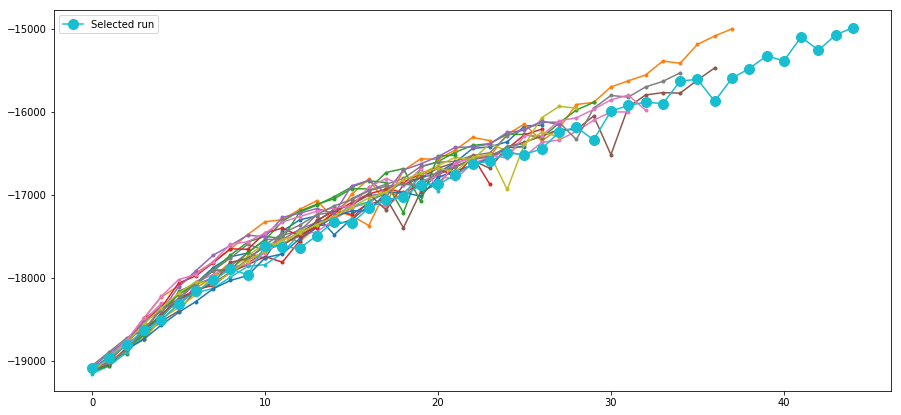

In [27]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

In [29]:
Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
T_idx_unique = np.arange(T).reshape(-1,1)

A = keras.utils.to_categorical(np.arange(T), num_classes=T) #fast way
print("shape of annotator representation (T, R_t)=", A.shape)

shape of annotator representation (T, R_t)= (203, 203)


shape of annotator representation (T, R_t)= (203, 2)


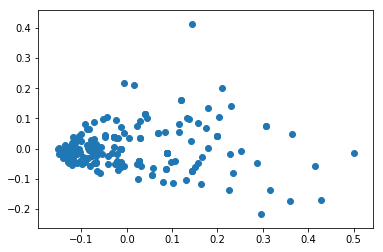

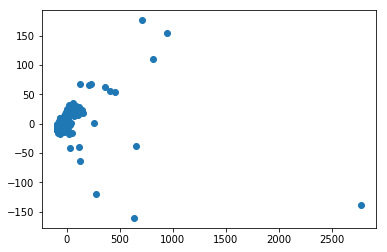

array([[1.800e+01, 1.700e+01],
       [2.520e+02, 2.130e+02],
       [4.600e+01, 5.200e+01],
       [3.500e+02, 3.630e+02],
       [1.940e+02, 1.350e+02],
       [1.610e+03, 2.383e+03],
       [6.370e+02, 6.570e+02],
       [1.480e+02, 1.420e+02],
       [2.300e+01, 2.200e+01],
       [3.790e+02, 4.070e+02],
       [9.100e+01, 7.800e+01],
       [5.600e+01, 5.300e+01],
       [1.210e+02, 1.090e+02],
       [6.300e+02, 5.380e+02],
       [6.700e+01, 7.700e+01],
       [3.320e+02, 3.280e+02],
       [1.400e+01, 1.100e+01],
       [8.000e+01, 6.000e+01],
       [1.000e+01, 1.900e+01],
       [5.600e+01, 7.900e+01],
       [6.400e+01, 9.100e+01],
       [1.270e+02, 9.800e+01],
       [1.050e+02, 1.000e+02],
       [5.000e+00, 1.000e+01],
       [5.200e+01, 6.300e+01],
       [4.800e+01, 6.200e+01],
       [8.000e+01, 6.500e+01],
       [2.170e+02, 2.760e+02],
       [1.200e+01, 1.300e+01],
       [1.100e+01, 1.900e+01],
       [2.600e+01, 3.400e+01],
       [8.900e+01, 1.060e+02],
       [

In [30]:
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, r_obs.argmax(axis=-1))

#A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], Kl**2) #flatten
A_rep = np.zeros((conf_mat.shape[0], Kl))
for t in range(A_rep.shape[0]):
    A_rep[t] = JS_confmatrixs(conf_mat_norm[t], np.identity(Kl),raw=True) #distancia a I (MV)
    
print("shape of annotator representation (T, R_t)=", A_rep.shape)

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()


A_rep = np.zeros((y_obs.shape[1], Kl))
for i in range(N):
    for l, t_idx in enumerate(T_idx[i]):
        obs_t = Y_ann_train[i][l].argmax(axis=-1)
        A_rep[t_idx, obs_t] += 1
    
from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()
A_rep

In [57]:
#different M_seted??
M_seted = 3

In [84]:
gMixture_Ind2 = GroupMixtureInd(max_L,Kl=Kl,M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Ind2.define_model("default rnn text", embed=embedding_matrix)

#gMixture_Ind.define_model_group("mlp", T, M_seted, 1, BatchN=True, embed=True, embed_M=A) #con o sin BN
#gMixture_Ind.define_model_group("keras_shallow", T, M_seted,embed=True, embed_M=A) #pareciera ser necesario pr-init

#logL_hists,i_r = gMixture_Ind2.multiples_run(20,X_train,Y_ann_train, T_idx, A=[], batch_size=BATCH_SIZE,
#                                    pre_init_z=3,pre_init_g=0,max_iter=EPOCHS_BASE,tolerance=TOL)

In [89]:
gMixture_Ind2.base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 300)           3900300   
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, 50, 64)            70272     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 64)            0         
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 32)                9408      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 3,980,046
Trainable params: 79,746
Non-trainable params: 3,900,300
_____________________________________________________________

In [90]:
gMixture_Ind2.base_model.get_weights()[0]

array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.04656  ,  0.21318  , -0.0074364, ...,  0.0090611, -0.20989  ,
         0.053913 ],
       [-0.29712  ,  0.094049 , -0.096662 , ...,  0.059717 , -0.22853  ,
         0.29602  ],
       ...,
       [-0.17884  , -0.14741  , -0.033911 , ..., -0.14063  ,  0.10388  ,
        -0.18098  ],
       [ 0.93694  ,  0.25786  ,  0.11079  , ..., -0.18601  , -0.26421  ,
        -0.31801  ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ]], dtype=float32)

In [87]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04656   ,  0.21318001, -0.0074364 , ...,  0.0090611 ,
        -0.20988999,  0.053913  ],
       [-0.29712   ,  0.094049  , -0.096662  , ...,  0.059717  ,
        -0.22853   ,  0.29602   ],
       ...,
       [-0.17884   , -0.14741001, -0.033911  , ..., -0.14063001,
         0.10388   , -0.18098   ],
       [ 0.93694001,  0.25786   ,  0.11079   , ..., -0.18601   ,
        -0.26420999, -0.31801   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [139]:
bla = keras.models.clone_model(gMixture_Ind2.base_model, )
bla.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 300)           3900300   
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, 50, 64)            70272     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 64)            0         
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 32)                9408      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 3,980,046
Trainable params: 79,746
Non-trainable params: 3,900,300
_____________________________________________________________

In [145]:

for n in range(len(bla.layers)):
#zip(bla.layers, gMixture_Ind2.base_model.layers):
    if not bla.layers[n].trainable:
        bla.layers[n].set_weights( gMixture_Ind2.base_model.layers[n].get_weights())
bla.compile(loss='categorical_crossentropy',optimizer='adam')

In [146]:
bla.layers[0].get_weights()

[array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        [ 0.04656  ,  0.21318  , -0.0074364, ...,  0.0090611, -0.20989  ,
          0.053913 ],
        [-0.29712  ,  0.094049 , -0.096662 , ...,  0.059717 , -0.22853  ,
          0.29602  ],
        ...,
        [-0.17884  , -0.14741  , -0.033911 , ..., -0.14063  ,  0.10388  ,
         -0.18098  ],
        [ 0.93694  ,  0.25786  ,  0.11079  , ..., -0.18601  , -0.26421  ,
         -0.31801  ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ]], dtype=float32)]

In [148]:
bla.non_trainable_weights

[<tf.Variable 'embedding_2_7/embeddings:0' shape=(13001, 300) dtype=float32_ref>]

In [143]:
bla.layers

In [147]:
bla.get_weights()[0]

array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.04656  ,  0.21318  , -0.0074364, ...,  0.0090611, -0.20989  ,
         0.053913 ],
       [-0.29712  ,  0.094049 , -0.096662 , ...,  0.059717 , -0.22853  ,
         0.29602  ],
       ...,
       [-0.17884  , -0.14741  , -0.033911 , ..., -0.14063  ,  0.10388  ,
        -0.18098  ],
       [ 0.93694  ,  0.25786  ,  0.11079  , ..., -0.18601  , -0.26421  ,
        -0.31801  ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ]], dtype=float32)

In [80]:
gMixture_Ind2.alphas_t

array([[9.99999762e-01, 1.41227346e-07, 1.50879970e-07],
       [9.99999762e-01, 1.04674847e-07, 9.85603705e-08],
       [9.99999702e-01, 1.45401614e-07, 1.67403584e-07],
       [9.99999821e-01, 1.10871021e-07, 1.00524147e-07],
       [9.99999821e-01, 1.03724915e-07, 1.13370412e-07],
       [9.99999642e-01, 2.70334596e-07, 1.49987329e-07],
       [9.99999821e-01, 1.12073636e-07, 1.00377257e-07],
       [9.99999762e-01, 1.13595185e-07, 1.04035678e-07],
       [2.05278312e-07, 1.53321679e-07, 9.99999642e-01],
       [9.99999702e-01, 1.27684672e-07, 1.16920440e-07],
       [9.99999821e-01, 1.14600958e-07, 1.15427298e-07],
       [9.99999762e-01, 1.05568624e-07, 9.19641110e-08],
       [9.99999762e-01, 1.14106037e-07, 1.09860849e-07],
       [9.99999762e-01, 1.06983514e-07, 1.00497118e-07],
       [9.99999702e-01, 1.61055496e-07, 1.27291344e-07],
       [9.99999821e-01, 1.09820583e-07, 1.00353567e-07],
       [9.99999821e-01, 9.53484331e-08, 8.43275316e-08],
       [9.99999762e-01, 1.07182

In [55]:
Z_train_p = gMixture_Ind2.get_predictions_z(X_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Ind2.get_predictions_z(X_test)
Z_test_pred = Z_test_p.argmax(axis=-1)
prob_Gt = gMixture_Ind2.get_predictions_g(T_idx_unique) 

In [56]:
evaluate = Evaluation_metrics(model_UB,'keras',X_train.shape[0])

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

Train
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.8284,0.8284,0.8283


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.7685,0.7685,0.7685


In [38]:
gMixture_Ind3 = GroupMixtureInd(max_L,Kl=Kl,M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Ind3.define_model("default rnn text", embed=embedding_matrix)

gMixture_Ind3.define_model_group("mlp", A_rep.shape[1], Kl*M_seted, 1, BatchN=False, embed=False) #con BN

logL_hists,i_r = gMixture_Ind3.multiples_run(20,X_train,Y_ann_train, T_idx, A=A_rep, batch_size=BATCH_SIZE,
                                   pre_init_z=3,pre_init_g=15,max_iter=EPOCHS_BASE,tolerance=TOL) 

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.000322 mins
Lambda by group:  [1. 1. 1.]
Pre-train networks over *g* on 15 epochs... Done!
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (4999, 2)
Betas:  (3, 2, 2)
Q estimate:  (27746, 3, 2)
Iter 1/50
M step: done,  E step: done //  (in 4.23 sec)	logL: -18542.458	
Iter 2/50
M step: done,  E step: done //  (in 1.21 sec)	logL: -18211.821	Tol1: 0.01783	Tol2: 0.06830	
Iter 3/50
M step: done,  E step: done //  (in 1.18 sec)	logL: -18028.489	Tol1: 0.01007	Tol2: 0.05371	
Iter 4/50
M step: done,  E step: done //  (in 1.23 sec)	logL: -17873.598	Tol1: 0.00859	Tol2: 0.04387	
Iter 5/50
M step: done,  E step: done //  (in 1.19 sec)	logL: -17760.921	Tol1: 0.00630	Tol2: 0.06063	
Iter 6/50
M step: done,  E step: done //  (in 1.20 sec)	logL: -17668.288	Tol1: 0.00522	Tol2: 0.04508	
Iter 7/50
M step: done,  E step: done //  (in 1.23 sec)	logL: -17510.061	Tol1: 0.00896	Tol2: 0.06622	


M step: done,  E step: done //  (in 1.20 sec)	logL: -17125.081	Tol1: 0.01033	Tol2: 0.09834	
Iter 13/50
M step: done,  E step: done //  (in 1.16 sec)	logL: -17019.607	Tol1: 0.00616	Tol2: 0.04250	
Iter 14/50
M step: done,  E step: done //  (in 1.19 sec)	logL: -17014.295	Tol1: 0.00031	Tol2: 0.04069	
Iter 15/50
M step: done,  E step: done //  (in 1.17 sec)	logL: -17253.850	Tol1: 0.01408	Tol2: 0.06859	
Iter 16/50
M step: done,  E step: done //  (in 1.16 sec)	logL: -16855.699	Tol1: 0.02308	Tol2: 0.17896	
Iter 17/50
M step: done,  E step: done //  (in 1.19 sec)	logL: -16741.253	Tol1: 0.00679	Tol2: 0.07049	
Iter 18/50
M step: done,  E step: done //  (in 1.17 sec)	logL: -16652.157	Tol1: 0.00532	Tol2: 0.03488	
Iter 19/50
M step: done,  E step: done //  (in 1.17 sec)	logL: -16928.862	Tol1: 0.01662	Tol2: 0.02927	
Finished training!
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.000302 mins
Lambda by group:  [1. 1. 1.]
Pre-train networks over *g* on 15 epochs... Done!
Pre-trai

Pre-train networks over *g* on 15 epochs... Done!
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (4999, 2)
Betas:  (3, 2, 2)
Q estimate:  (27746, 3, 2)
Iter 1/50
M step: done,  E step: done //  (in 4.29 sec)	logL: -18592.319	
Iter 2/50
M step: done,  E step: done //  (in 1.23 sec)	logL: -18462.172	Tol1: 0.00700	Tol2: 0.46277	
Iter 3/50
M step: done,  E step: done //  (in 1.20 sec)	logL: -18309.826	Tol1: 0.00825	Tol2: 0.05462	
Iter 4/50
M step: done,  E step: done //  (in 1.20 sec)	logL: -18203.614	Tol1: 0.00580	Tol2: 0.01415	
Finished training!
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.000401 mins
Lambda by group:  [1. 1. 1.]
Pre-train networks over *g* on 15 epochs... Done!
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (4999, 2)
Betas:  (3, 2, 2)
Q estimate:  (27746, 3, 2)
Iter 1/50
M step: done,  E step: done //  (in 4.15 sec)	logL: -18597.663	
Iter 2/50
M step: done,  E step: done //  (in 1.22 sec)	logL: -18376.597	Tol1: 0.01189	To

M step: done,  E step: done //  (in 1.17 sec)	logL: -17816.620	Tol1: 0.00777	Tol2: 0.05452	
Iter 9/50
M step: done,  E step: done //  (in 1.24 sec)	logL: -17724.956	Tol1: 0.00514	Tol2: 0.04342	
Iter 10/50
M step: done,  E step: done //  (in 1.19 sec)	logL: -17665.439	Tol1: 0.00336	Tol2: 0.03581	
Iter 11/50
M step: done,  E step: done //  (in 1.16 sec)	logL: -17564.437	Tol1: 0.00572	Tol2: 0.06479	
Iter 12/50
M step: done,  E step: done //  (in 1.18 sec)	logL: -17475.830	Tol1: 0.00504	Tol2: 0.06811	
Iter 13/50
M step: done,  E step: done //  (in 1.19 sec)	logL: -17347.057	Tol1: 0.00737	Tol2: 0.05455	
Iter 14/50
M step: done,  E step: done //  (in 1.18 sec)	logL: -17337.940	Tol1: 0.00053	Tol2: 0.02480	
Finished training!
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.000267 mins
Lambda by group:  [1. 1. 1.]
Pre-train networks over *g* on 15 epochs... Done!
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (4999, 2)
Betas:  (3, 2, 2)
Q estimate:  (27746, 3, 2

In [39]:
Z_train_p = gMixture_Ind3.get_predictions_z(X_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Ind3.get_predictions_z(X_test)
Z_test_pred = Z_test_p.argmax(axis=-1)
prob_Gt = gMixture_Ind3.get_predictions_g(A_rep) 

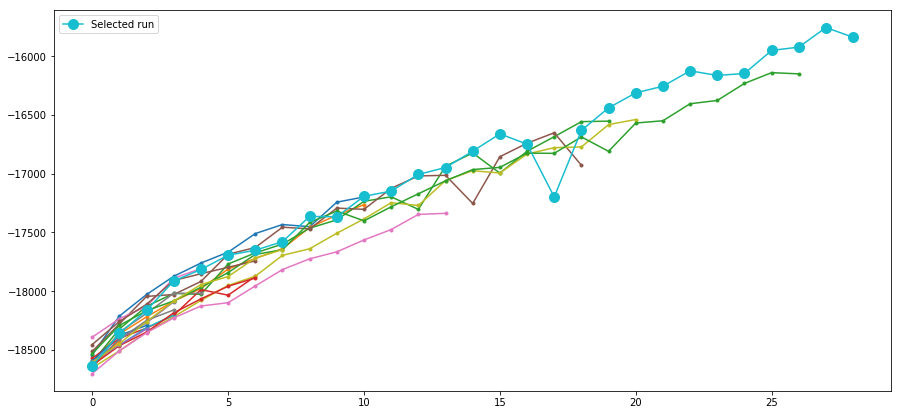

In [44]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Compare trained models

In [20]:
#Import it:
from code.evaluation import Evaluation_metrics

In [19]:
evaluate = Evaluation_metrics(model_UB,'keras',X_train.shape[0])
print("*** Upper bound (Train with GT) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Upper bound (Train with GT) ***
Train
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.8122,0.8122,0.8108


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.7492,0.7492,0.7469


In [ ]:
#upper bound global confusion matrix..
prob_Yz = generate_confusionM(Z_train_pred, label_I.y_obs_repeat)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)

*** Soft-Majority (Train with softMV) ***
Train
Calculate confusion matrix on repeat version


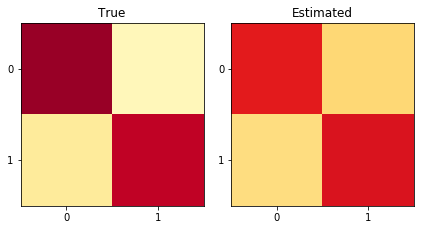

JS divergence: 0.0343	Norm Frobenius: 0.1528


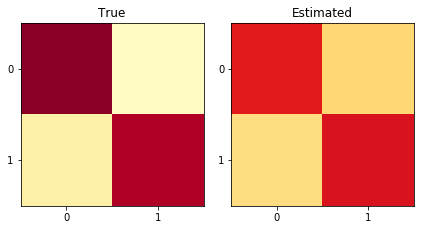

JS divergence: 0.0535	Norm Frobenius: 0.1798


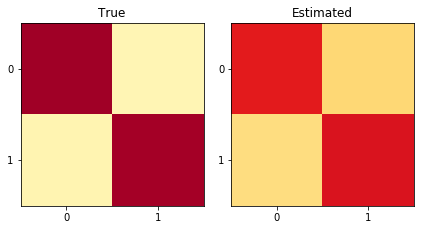

JS divergence: 0.0386	Norm Frobenius: 0.1639


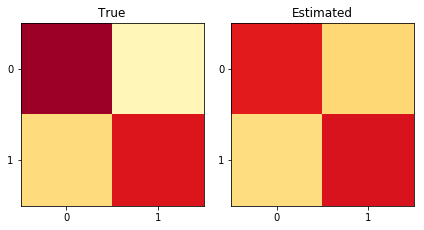

JS divergence: 0.0269	Norm Frobenius: 0.1358


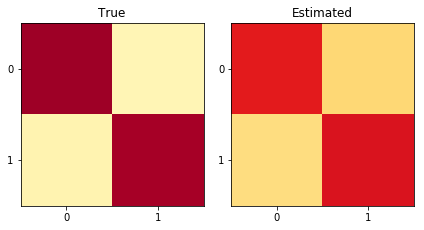

JS divergence: 0.0391	Norm Frobenius: 0.1647


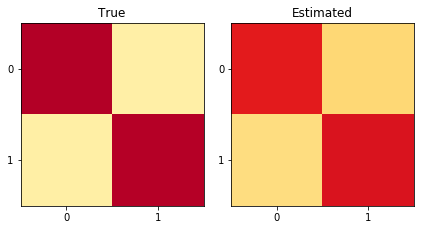

JS divergence: 0.0204	Norm Frobenius: 0.1265


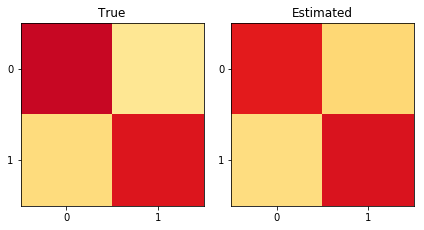

JS divergence: 0.0044	Norm Frobenius: 0.0633


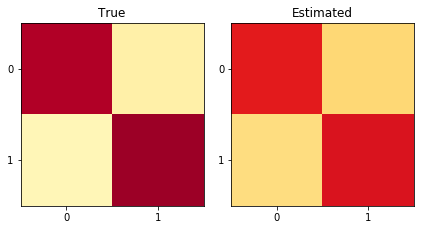

JS divergence: 0.0344	Norm Frobenius: 0.1547


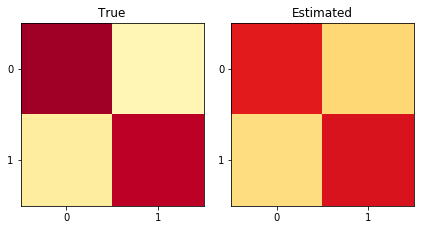

JS divergence: 0.0289	Norm Frobenius: 0.1448


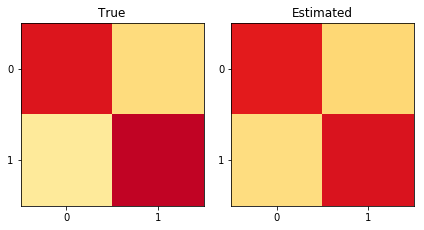

JS divergence: 0.0038	Norm Frobenius: 0.0562


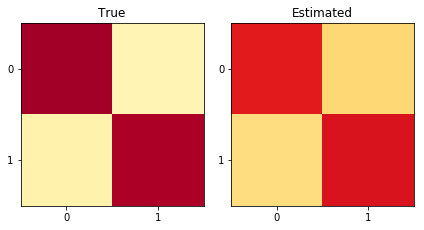

JS divergence: 0.0344	Norm Frobenius: 0.1565


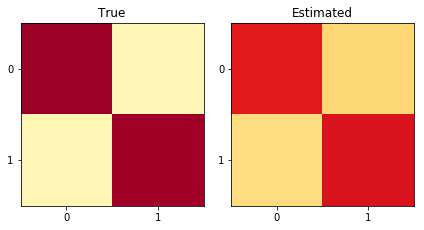

JS divergence: 0.0437	Norm Frobenius: 0.1718


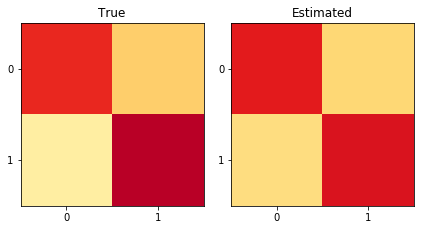

JS divergence: 0.0072	Norm Frobenius: 0.0753


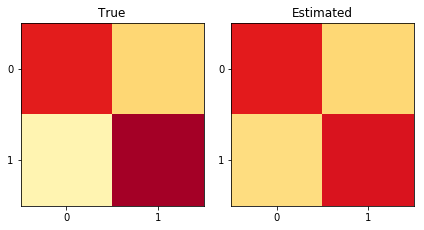

JS divergence: 0.0148	Norm Frobenius: 0.1000


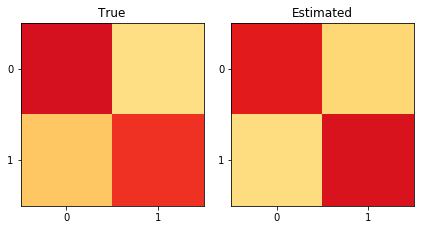

JS divergence: 0.0044	Norm Frobenius: 0.0678
Calculate confusion matrix on global version


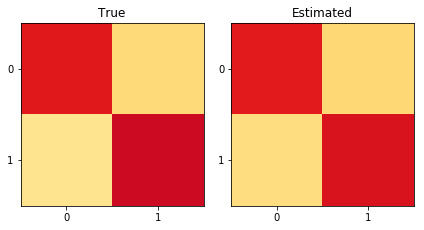

JS divergence: 0.0011	Norm Frobenius: 0.0310
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS
0,All,0.5409,0.5409,0.4561,0.1869,0.061,0.1438,0.0282,0.031,0.0011


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.5595,0.5595,0.4251


In [21]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',X_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
prob_Yzt = np.tile( mv_conf_probas, (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_probas)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train
Calculate confusion matrix on repeat version


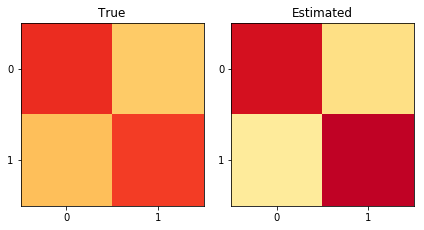

JS divergence: 0.0236	Norm Frobenius: 0.1524


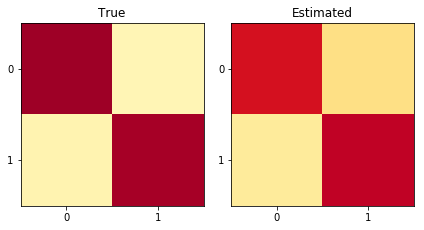

JS divergence: 0.0186	Norm Frobenius: 0.1060


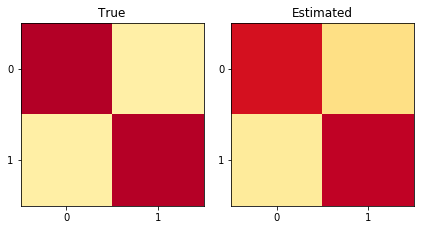

JS divergence: 0.0068	Norm Frobenius: 0.0698


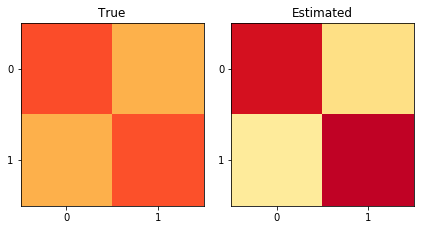

JS divergence: 0.0417	Norm Frobenius: 0.2104


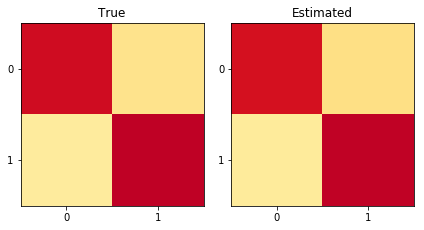

JS divergence: 0.0002	Norm Frobenius: 0.0127


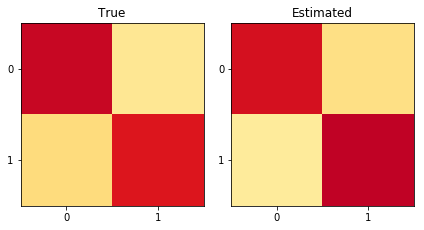

JS divergence: 0.0060	Norm Frobenius: 0.0706


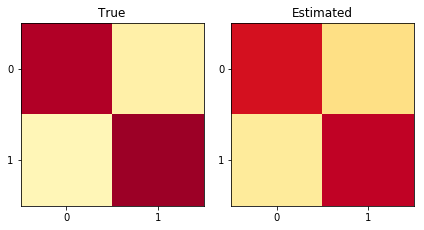

JS divergence: 0.0136	Norm Frobenius: 0.0906


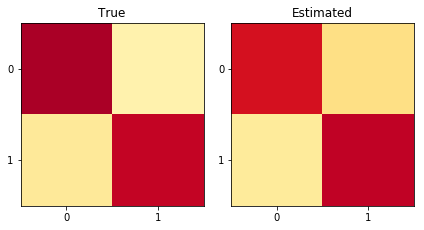

JS divergence: 0.0100	Norm Frobenius: 0.0821


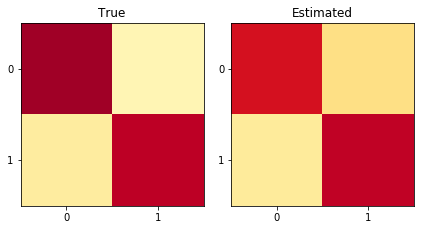

JS divergence: 0.0143	Norm Frobenius: 0.0949


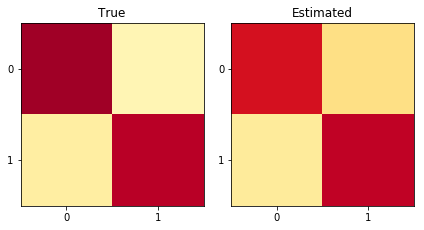

JS divergence: 0.0152	Norm Frobenius: 0.0973


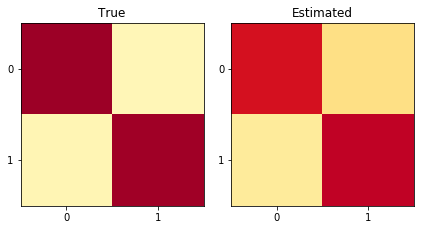

JS divergence: 0.0214	Norm Frobenius: 0.1118


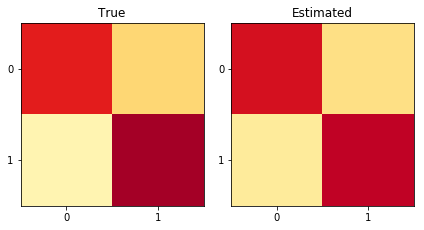

JS divergence: 0.0048	Norm Frobenius: 0.0565


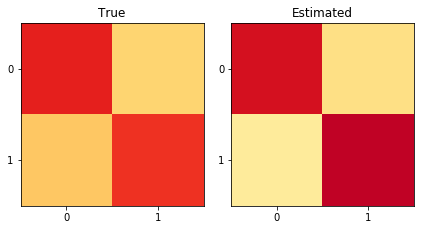

JS divergence: 0.0174	Norm Frobenius: 0.1283


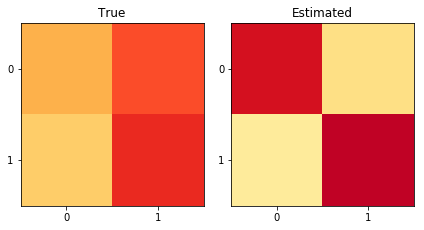

JS divergence: 0.0805	Norm Frobenius: 0.3158


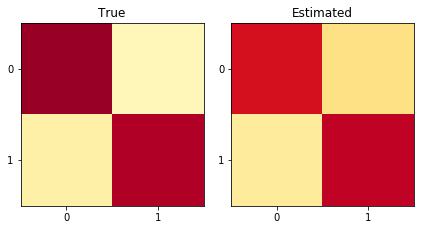

JS divergence: 0.0208	Norm Frobenius: 0.1100
Calculate confusion matrix on global version


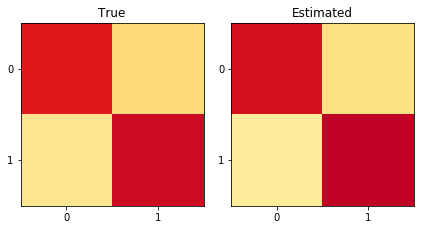

JS divergence: 0.0019	Norm Frobenius: 0.0399
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS
0,All,0.5835,0.5835,0.5808,0.1788,0.0601,0.1329,0.0266,0.0399,0.0019


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.5165,0.5165,0.5056


In [23]:
evaluate = Evaluation_metrics(model_mvhard,'keras',X_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
prob_Yzt = np.tile( mv_conf_onehot, (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_onehot)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train
Calculate confusion matrix on repeat version


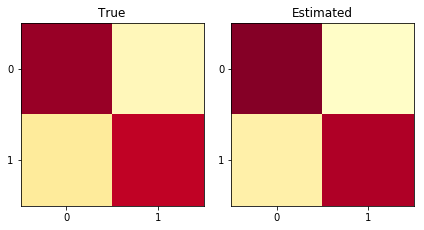

JS divergence: 0.0061	Norm Frobenius: 0.0388


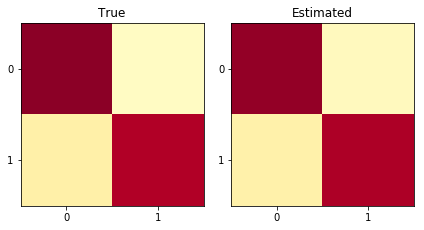

JS divergence: 0.0010	Norm Frobenius: 0.0139


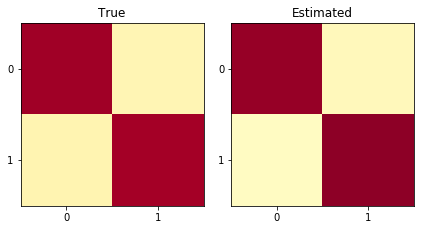

JS divergence: 0.0052	Norm Frobenius: 0.0373


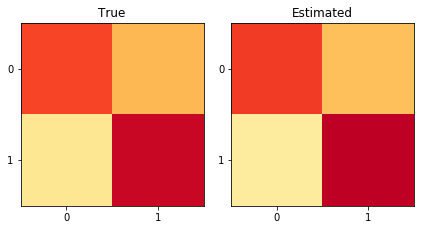

JS divergence: 0.0009	Norm Frobenius: 0.0273


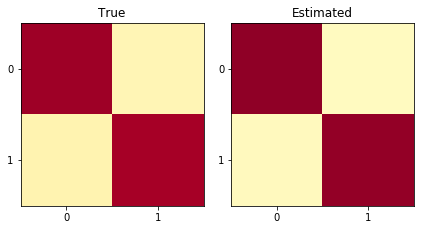

JS divergence: 0.0042	Norm Frobenius: 0.0348


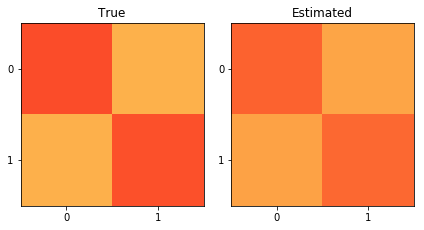

JS divergence: 0.0015	Norm Frobenius: 0.0445


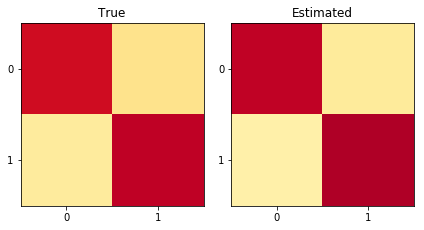

JS divergence: 0.0025	Norm Frobenius: 0.0407


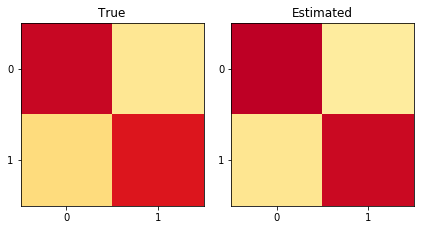

JS divergence: 0.0028	Norm Frobenius: 0.0485


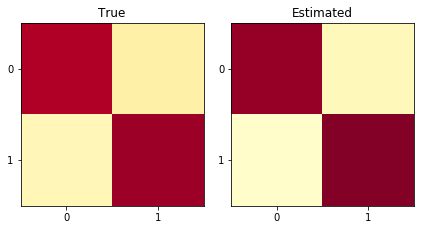

JS divergence: 0.0116	Norm Frobenius: 0.0518


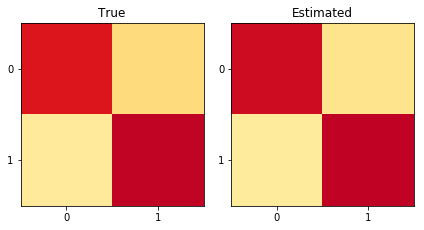

JS divergence: 0.0012	Norm Frobenius: 0.0333


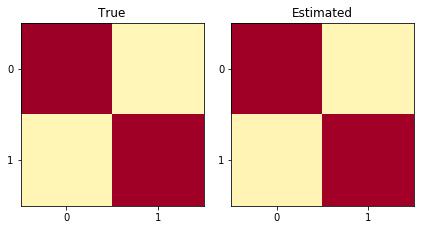

JS divergence: 0.0000	Norm Frobenius: 0.0037


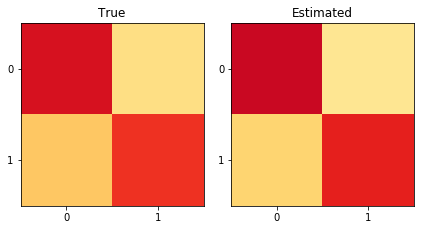

JS divergence: 0.0019	Norm Frobenius: 0.0421


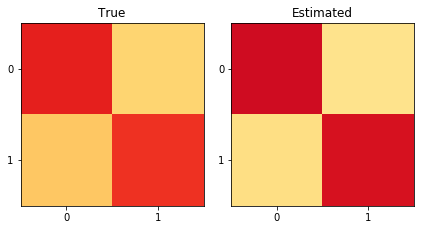

JS divergence: 0.0079	Norm Frobenius: 0.0900


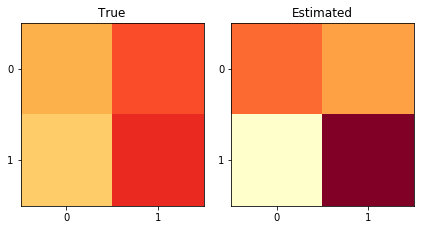

JS divergence: 0.0902	Norm Frobenius: 0.2423


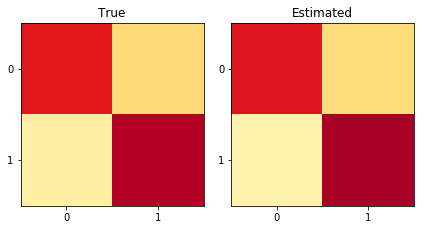

JS divergence: 0.0007	Norm Frobenius: 0.0204
Calculate confusion matrix on global version


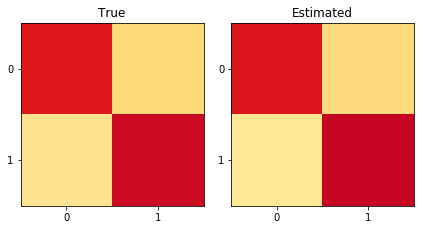

JS divergence: 0.0003	Norm Frobenius: 0.0168
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS
0,All,0.5717,0.5717,0.5276,0.0744,0.0205,0.038,0.0047,0.0168,0.0003


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.5242,0.5242,0.5051


In [28]:
evaluate = Evaluation_metrics(model_ds,'keras',X_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = ds_conf.mean(axis=0))

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train
Calculate confusion matrix on repeat version


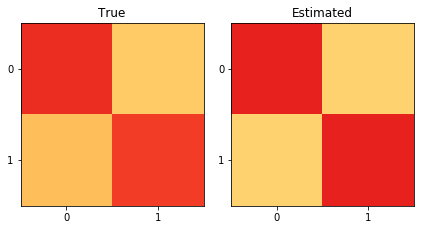

JS divergence: 0.0018	Norm Frobenius: 0.0454


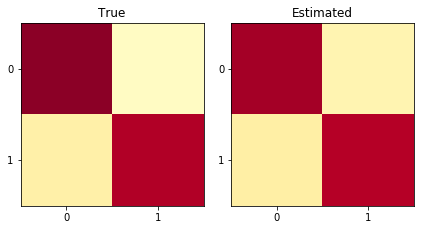

JS divergence: 0.0051	Norm Frobenius: 0.0357


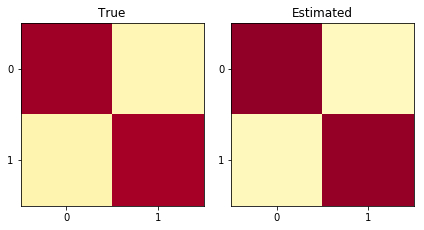

JS divergence: 0.0034	Norm Frobenius: 0.0318


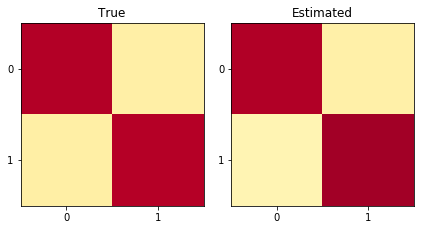

JS divergence: 0.0018	Norm Frobenius: 0.0287


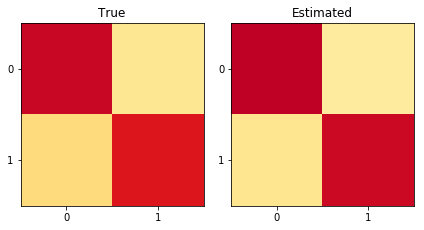

JS divergence: 0.0023	Norm Frobenius: 0.0440


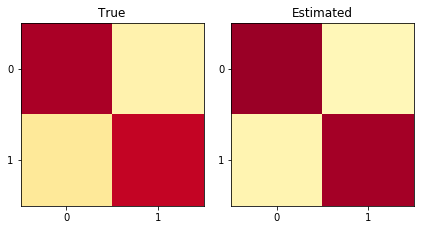

JS divergence: 0.0059	Norm Frobenius: 0.0543


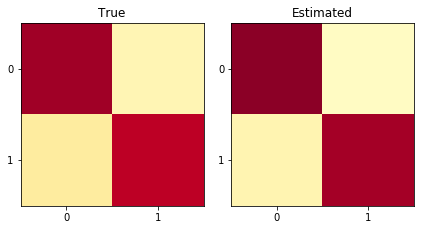

JS divergence: 0.0063	Norm Frobenius: 0.0469


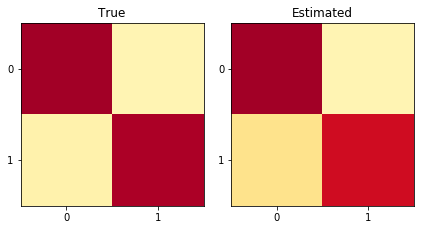

JS divergence: 0.0068	Norm Frobenius: 0.0661


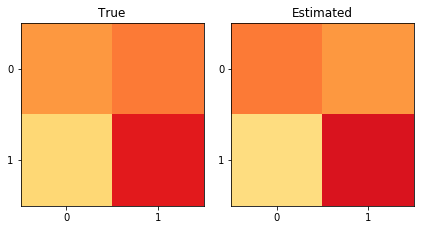

JS divergence: 0.0025	Norm Frobenius: 0.0572


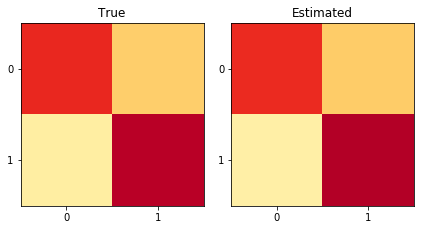

JS divergence: 0.0001	Norm Frobenius: 0.0094


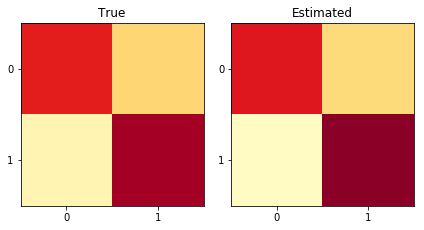

JS divergence: 0.0050	Norm Frobenius: 0.0385


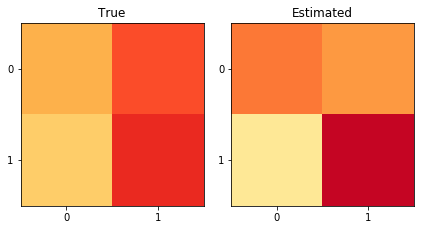

JS divergence: 0.0193	Norm Frobenius: 0.1498


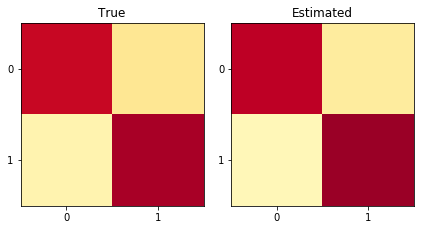

JS divergence: 0.0018	Norm Frobenius: 0.0298


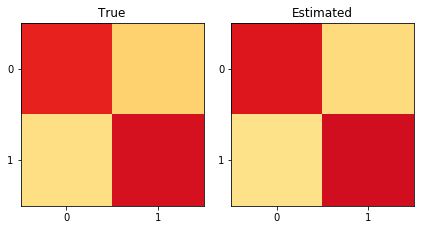

JS divergence: 0.0008	Norm Frobenius: 0.0289


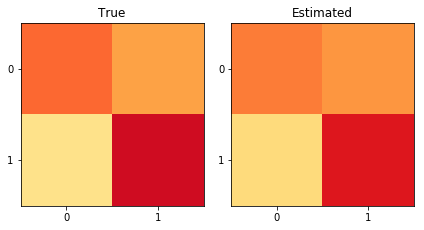

JS divergence: 0.0017	Norm Frobenius: 0.0431
Calculate confusion matrix on global version


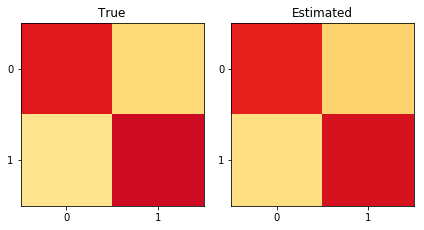

JS divergence: 0.0011	Norm Frobenius: 0.0314
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS,RMSE mean,RMSE w
0,All,0.6527,0.6527,0.6524,0.09,0.0285,0.0358,0.0039,0.0314,0.0011,0.2006,0.1947


A result


,ACC imiting Annot mean,Cross-entropy mean,ACC imiting Annot wmean,Cross entropy wmean
0,0.6542,0.6245,0.633,0.6359


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.5848,0.5848,0.5848


In [21]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(X_train,data=Z_train_p)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt,conf_true_G =confe_matrix_G, conf_pred_G = prob_Yzt.mean(axis=0))

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours Global multiples runs***
Train
Calculate confusion matrix on repeat version


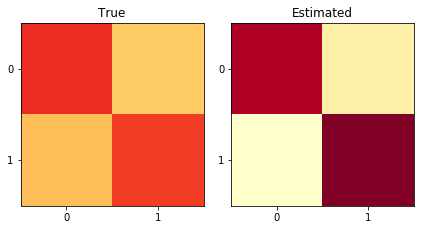

JS divergence: 0.1111	Norm Frobenius: 0.2694
Groups probabilities:  [0.9945 0.0055 0.    ]


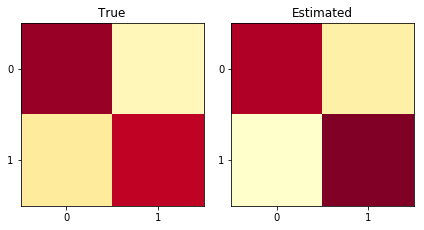

JS divergence: 0.0373	Norm Frobenius: 0.1032
Groups probabilities:  [1. 0. 0.]


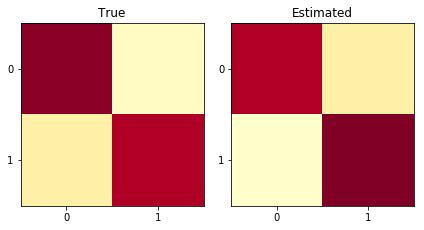

JS divergence: 0.0354	Norm Frobenius: 0.0929
Groups probabilities:  [1. 0. 0.]


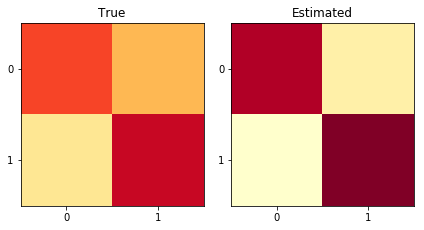

JS divergence: 0.0731	Norm Frobenius: 0.2086
Groups probabilities:  [1. 0. 0.]


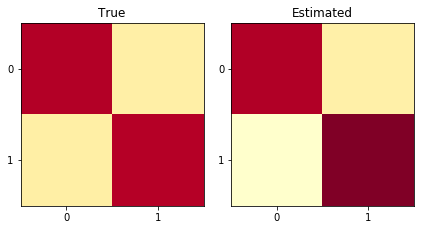

JS divergence: 0.0271	Norm Frobenius: 0.0788
Groups probabilities:  [1. 0. 0.]


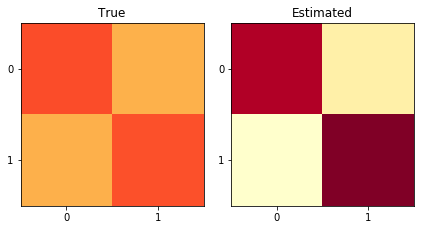

JS divergence: 0.1439	Norm Frobenius: 0.3287
Groups probabilities:  [0.9943 0.0057 0.    ]


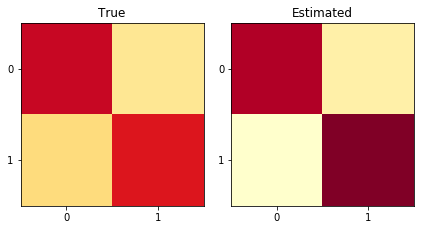

JS divergence: 0.0625	Norm Frobenius: 0.1661
Groups probabilities:  [1. 0. 0.]


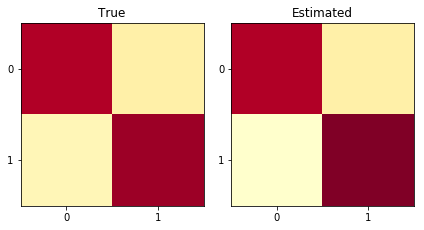

JS divergence: 0.0133	Norm Frobenius: 0.0415
Groups probabilities:  [1. 0. 0.]


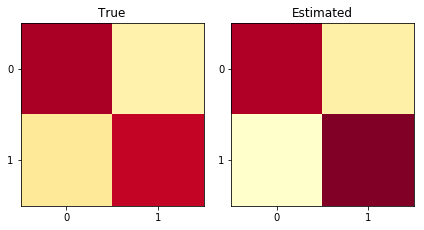

JS divergence: 0.0366	Norm Frobenius: 0.1034
Groups probabilities:  [1. 0. 0.]


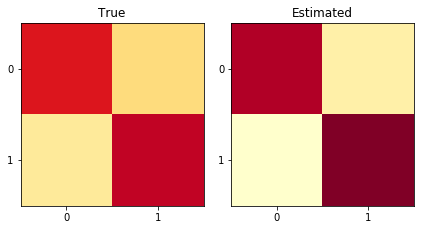

JS divergence: 0.0456	Norm Frobenius: 0.1335
Groups probabilities:  [1. 0. 0.]


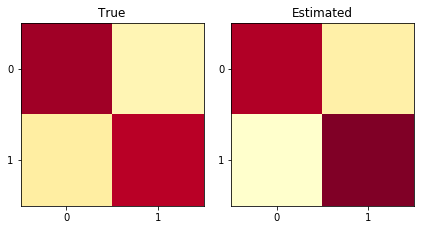

JS divergence: 0.0301	Norm Frobenius: 0.0865
Groups probabilities:  [1. 0. 0.]


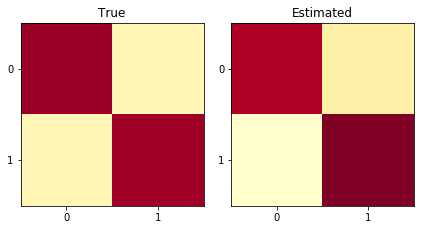

JS divergence: 0.0175	Norm Frobenius: 0.0560
Groups probabilities:  [9.999e-01 1.000e-04 0.000e+00]


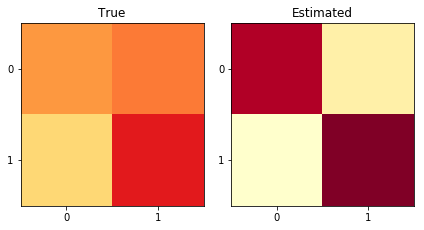

JS divergence: 0.1490	Norm Frobenius: 0.3534
Groups probabilities:  [9.992e-01 8.000e-04 0.000e+00]


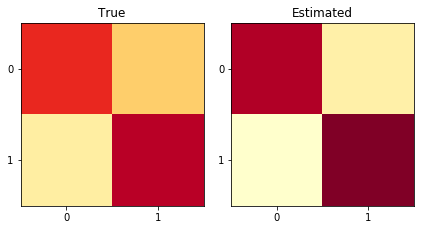

JS divergence: 0.0474	Norm Frobenius: 0.1508
Groups probabilities:  [1. 0. 0.]


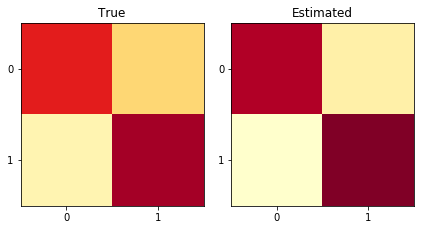

JS divergence: 0.0323	Norm Frobenius: 0.1201
Groups probabilities:  [1. 0. 0.]
Calculate confusion matrix on global version


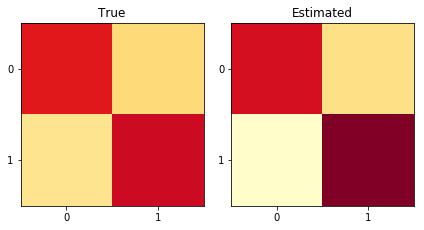

JS divergence: 0.0392	Norm Frobenius: 0.1239
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS,RMSE mean,RMSE w
0,All,0.7946,0.7946,0.7943,0.208,0.0898,0.1743,0.0641,0.1239,0.0392,0.1215,0.1008


A result


,ACC imiting Annot mean,Cross-entropy mean,ACC imiting Annot wmean,Cross entropy wmean
0,0.753,0.5343,0.7484,0.5373


Test


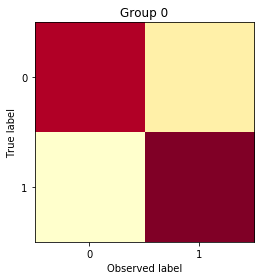

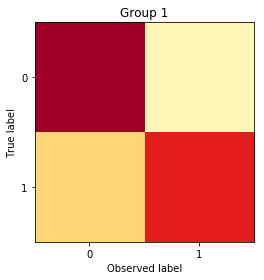

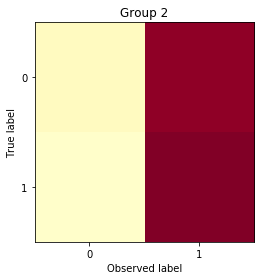

Inertia JS: 0.2723021299487364
Inertia NormF: 0.4845044063118385
A result


,Groups,Prob,T(g),Entropy,Diag mean,Isim (JS),S_raykar,S_bias,C_bias,Iner JS,Iner NormF,Accuracy,F1 (micro)
0,0,0.8706,176,0.1729,0.9469,0.9724,0.8938,0.0517,1,0.2723,0.4845,0.5955,0.5955
1,1,0.0192,3,0.4120,0.8362,0.9107,0.6724,0.0940,0,0.2723,0.4845,0.5510,0.5510
2,2,0.1102,22,0.0881,0.5129,0.5495,0.0257,0.4813,1,0.2723,0.4845,0.5408,0.5408


A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.5875,0.5875,0.584


In [28]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(X_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Global.calculate_Yz()
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(X_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(X_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs (Uniform priors) ***") #groups uniform...

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(X_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours Individual2 multiples runs***
Train
Calculate confusion matrix on repeat version


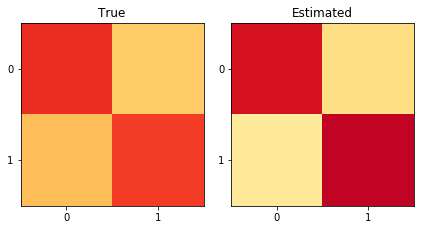

JS divergence: 0.0220	Norm Frobenius: 0.1478
Groups probabilities:  [1. 0. 0.]


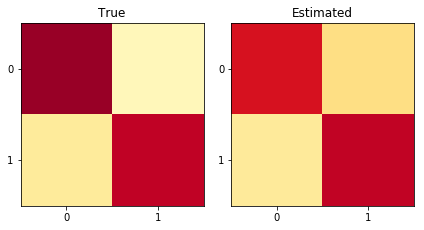

JS divergence: 0.0211	Norm Frobenius: 0.1117
Groups probabilities:  [1. 0. 0.]


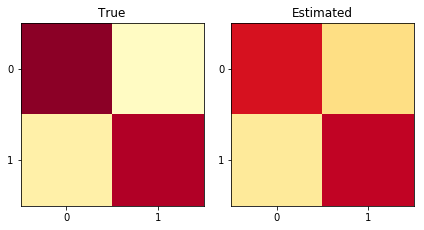

JS divergence: 0.0349	Norm Frobenius: 0.1335
Groups probabilities:  [1. 0. 0.]


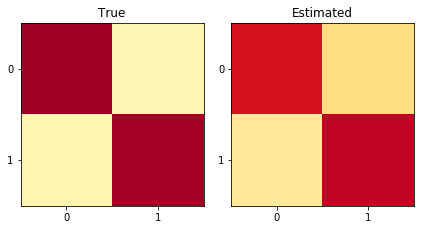

JS divergence: 0.0194	Norm Frobenius: 0.1096
Groups probabilities:  [1. 0. 0.]


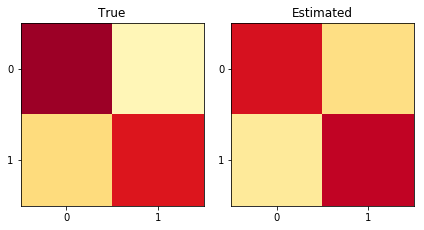

JS divergence: 0.0227	Norm Frobenius: 0.1222
Groups probabilities:  [1. 0. 0.]


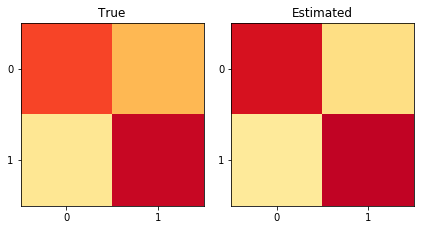

JS divergence: 0.0095	Norm Frobenius: 0.1023
Groups probabilities:  [1. 0. 0.]


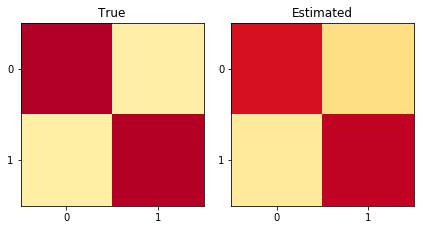

JS divergence: 0.0078	Norm Frobenius: 0.0747
Groups probabilities:  [1. 0. 0.]


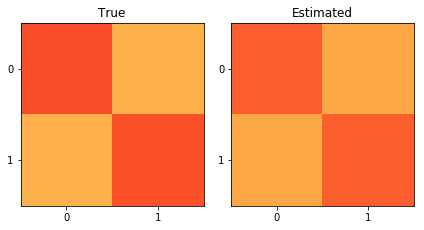

JS divergence: 0.0007	Norm Frobenius: 0.0304
Groups probabilities:  [0. 0. 1.]


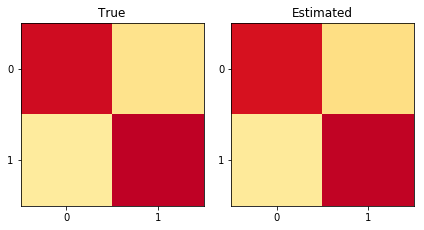

JS divergence: 0.0004	Norm Frobenius: 0.0178
Groups probabilities:  [1. 0. 0.]


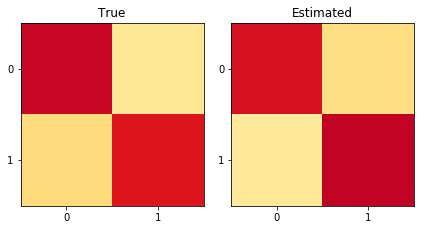

JS divergence: 0.0058	Norm Frobenius: 0.0698
Groups probabilities:  [1. 0. 0.]


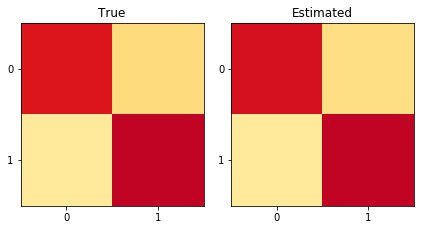

JS divergence: 0.0002	Norm Frobenius: 0.0142
Groups probabilities:  [1. 0. 0.]


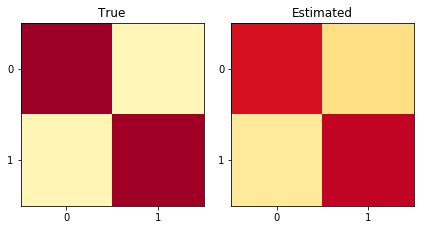

JS divergence: 0.0230	Norm Frobenius: 0.1170
Groups probabilities:  [1. 0. 0.]


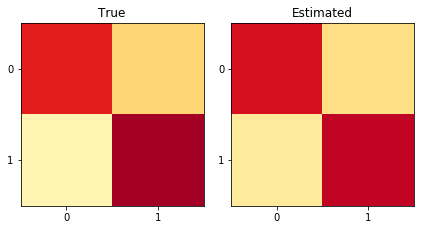

JS divergence: 0.0049	Norm Frobenius: 0.0561
Groups probabilities:  [1. 0. 0.]


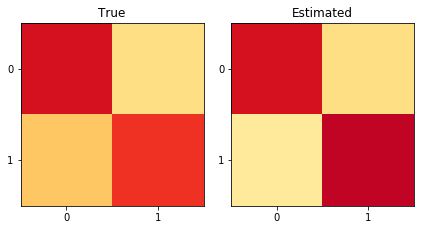

JS divergence: 0.0140	Norm Frobenius: 0.1150
Groups probabilities:  [1. 0. 0.]


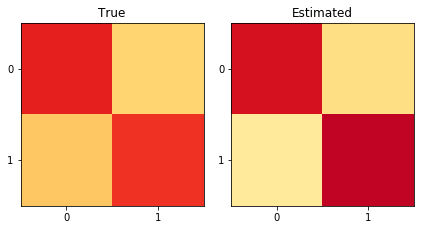

JS divergence: 0.0161	Norm Frobenius: 0.1240
Groups probabilities:  [1. 0. 0.]
Calculate confusion matrix on global version


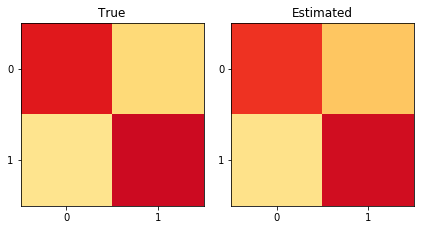

JS divergence: 0.0020	Norm Frobenius: 0.0464
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS,RMSE mean,RMSE w
0,All,0.6475,0.6475,0.6426,0.1403,0.0439,0.0929,0.0135,0.0464,0.002,0.1962,0.179


A result


,ACC imiting Annot mean,Cross-entropy mean,ACC imiting Annot wmean,Cross entropy wmean
0,0.6516,0.6372,0.6362,0.6446


Test


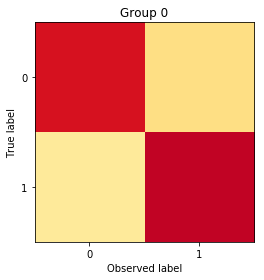

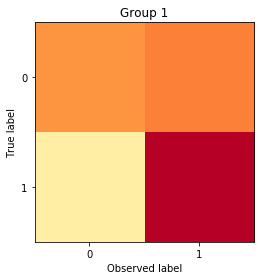

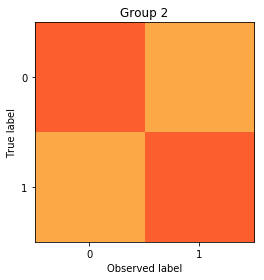

Inertia JS: 0.04544820161955839
Inertia NormF: 0.22682013513075835
A result


,Groups,Prob,T(g),Entropy,Diag mean,Isim (JS),S_raykar,S_bias,C_bias,Iner JS,Iner NormF,Accuracy,F1 (micro)
0,0,0.6108,123,0.4611,0.8241,0.9057,0.6483,0.0338,1,0.0454,0.2268,0.5642,0.5642
1,1,0.1921,39,0.5261,0.6796,0.8041,0.3591,0.2038,1,0.0454,0.2268,0.5408,0.5408
2,2,0.1970,40,0.6762,0.5917,0.7577,0.1834,0.0004,0,0.0454,0.2268,0.5418,0.5418


A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.543,0.543,0.5203


In [35]:
evaluate = Evaluation_metrics(gMixture_Ind2,'our1') 
aux = gMixture_Ind2.calculate_extra_components(X_train, A,calculate_pred_annotator=True,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Ind2.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual2 multiples runs***")

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Ind2.get_confusionM()
y_o_groups = gMixture_Ind2.get_predictions_groups(X_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours Individual3 multiples runs***
Train
Calculate confusion matrix on repeat version


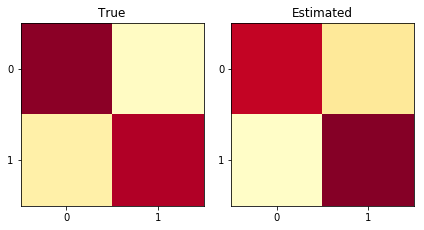

JS divergence: 0.0332	Norm Frobenius: 0.1067
Groups probabilities:  [0.429  0.2154 0.3557]


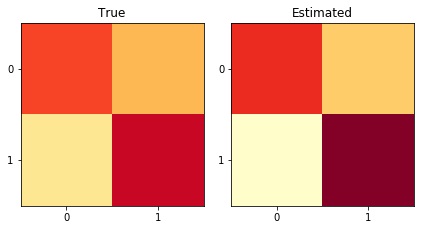

JS divergence: 0.0320	Norm Frobenius: 0.1144
Groups probabilities:  [0.0012 0.9988 0.    ]


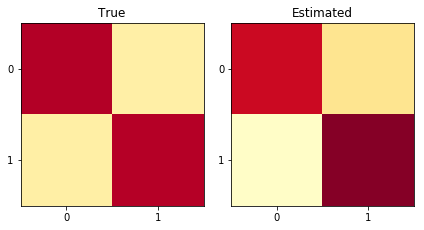

JS divergence: 0.0211	Norm Frobenius: 0.0851
Groups probabilities:  [0.4814 0.2965 0.2221]


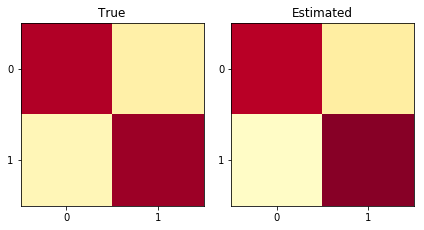

JS divergence: 0.0048	Norm Frobenius: 0.0326
Groups probabilities:  [0.3414 0.1689 0.4898]


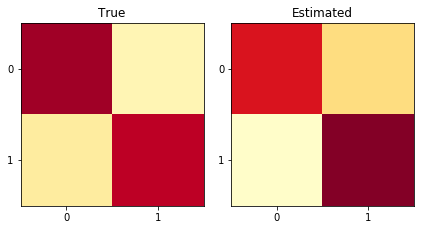

JS divergence: 0.0388	Norm Frobenius: 0.1332
Groups probabilities:  [0.3708 0.5257 0.1035]


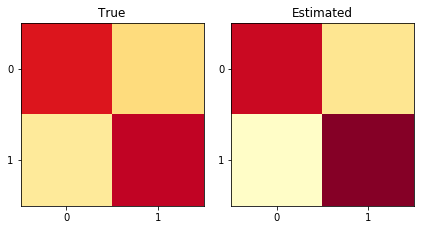

JS divergence: 0.0271	Norm Frobenius: 0.1014
Groups probabilities:  [0.504  0.2717 0.2244]


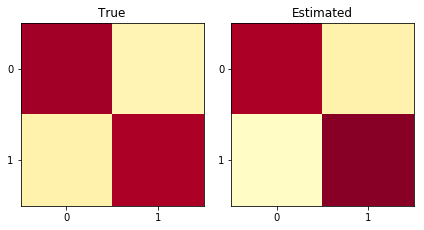

JS divergence: 0.0092	Norm Frobenius: 0.0509
Groups probabilities:  [0.2425 0.1079 0.6496]


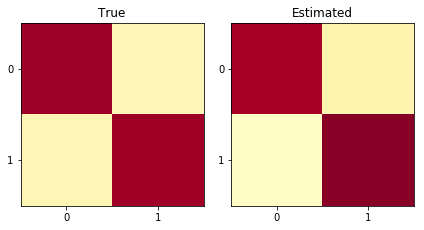

JS divergence: 0.0048	Norm Frobenius: 0.0339
Groups probabilities:  [0.191  0.0931 0.7159]


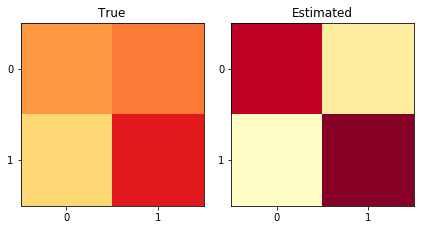

JS divergence: 0.1214	Norm Frobenius: 0.3329
Groups probabilities:  [0.3866 0.1796 0.4338]


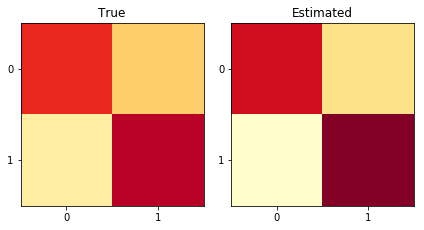

JS divergence: 0.0248	Norm Frobenius: 0.0997
Groups probabilities:  [0.5723 0.318  0.1096]


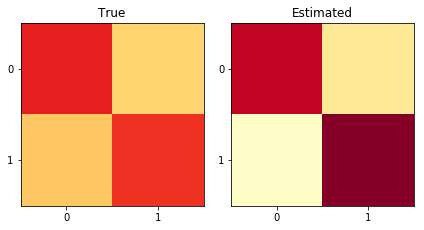

JS divergence: 0.0760	Norm Frobenius: 0.2233
Groups probabilities:  [0.4231 0.2348 0.3422]


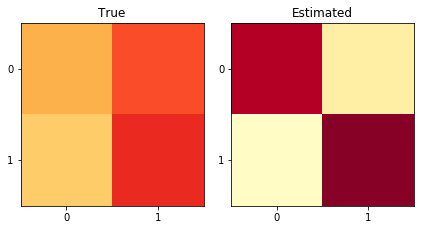

JS divergence: 0.1684	Norm Frobenius: 0.4093
Groups probabilities:  [0.3228 0.1455 0.5318]


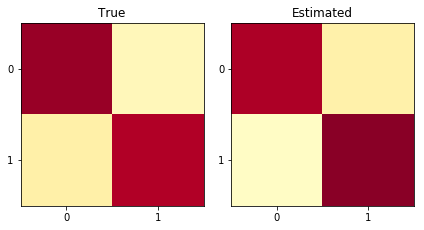

JS divergence: 0.0138	Norm Frobenius: 0.0653
Groups probabilities:  [0.2474 0.1232 0.6294]


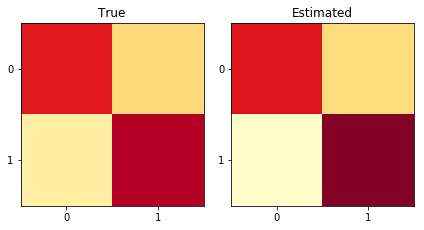

JS divergence: 0.0206	Norm Frobenius: 0.0744
Groups probabilities:  [5.046e-01 4.948e-01 5.000e-04]


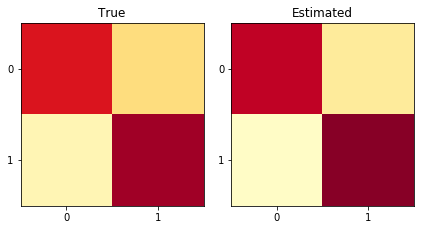

JS divergence: 0.0115	Norm Frobenius: 0.0728
Groups probabilities:  [0.4102 0.1976 0.3922]
Calculate confusion matrix on global version


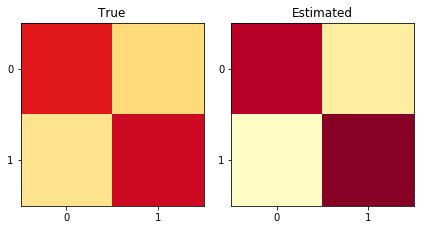

JS divergence: 0.0389	Norm Frobenius: 0.1426
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS,RMSE mean,RMSE w
0,All,0.7279,0.7279,0.7187,0.2105,0.0873,0.1575,0.0516,0.1426,0.0389,0.1623,0.1195


A result


,ACC imiting Annot mean,Cross-entropy mean,ACC imiting Annot wmean,Cross entropy wmean
0,0.6857,0.5879,0.7048,0.5709


Test


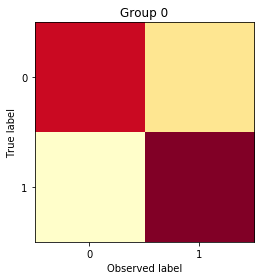

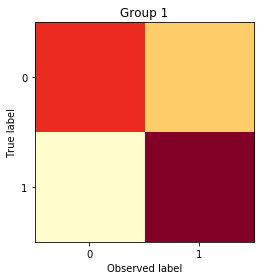

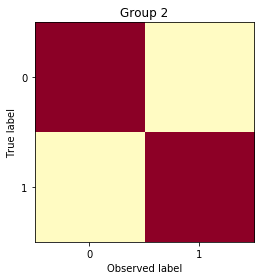

Inertia JS: 0.030299428997654837
Inertia NormF: 0.12612549384624447
A result


,Groups,Prob,T(g),Entropy,Diag mean,Isim (JS),S_raykar,S_bias,C_bias,Iner JS,Iner NormF,Accuracy,F1 (micro)
0,0,0.3099,62,0.2435,0.9126,0.9535,0.8252,0.0824,1,0.0303,0.1261,0.5997,0.5997
1,1,0.1822,36,0.3323,0.8483,0.9151,0.6966,0.1408,1,0.0303,0.1261,0.6115,0.6115
2,2,0.5079,103,0.1269,0.9722,0.9860,0.9444,0.0014,0,0.0303,0.1261,0.5758,0.5758


A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.5762,0.5762,0.5663


In [41]:
evaluate = Evaluation_metrics(gMixture_Ind3,'our1') 
aux = gMixture_Ind3.calculate_extra_components(X_train, A,calculate_pred_annotator=True,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Ind3.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual3 multiples runs***")

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Ind3.get_confusionM()
y_o_groups = gMixture_Ind3.get_predictions_groups(X_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

### project confusion matrices

In [42]:
def flatten_conf(m):
    return m.reshape(m.shape[0], np.prod(m.shape[1:]))

to_plot = flatten_conf(confe_matrix_R)

centroids_plot_G = flatten_conf(gMixture_Global.get_confusionM())
centroids_plot_I2 = flatten_conf(gMixture_Ind2.get_confusionM())
centroids_plot_I3 = flatten_conf(gMixture_Ind3.get_confusionM())

from sklearn.decomposition import PCA
model = PCA(2)

to_plot = model.fit_transform(to_plot)
centroids_plot_G = model.transform(centroids_plot_G)
centroids_plot_I2 = model.transform(centroids_plot_I2)
centroids_plot_I3 = model.transform(centroids_plot_I3)

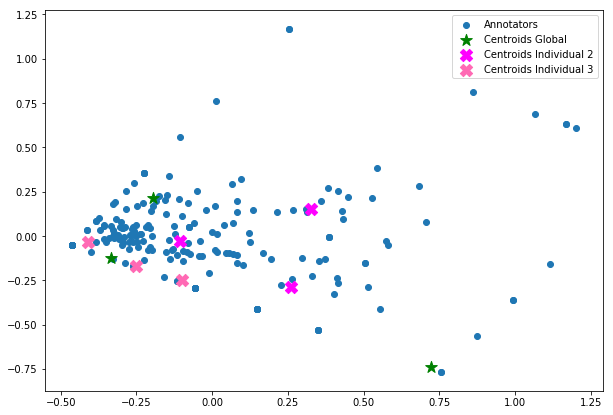

In [43]:
plt.figure(figsize=(10,7))
plt.scatter(to_plot[:,0], to_plot[:,1], label="Annotators")
plt.scatter(centroids_plot_G[:,0], centroids_plot_G[:,1], s=150,marker="*", color='g',label="Centroids Global")
plt.scatter(centroids_plot_I2[:,0], centroids_plot_I2[:,1],s=150, marker="X", color='magenta',label="Centroids Individual 2")
plt.scatter(centroids_plot_I3[:,0], centroids_plot_I3[:,1], s=150, marker="X", color='hotpink',label="Centroids Individual 3")

plt.legend()
plt.show()

In [ ]:
##plotear probabilidades de matriz  de conf..